# Проект "Прогнозирование количества заказов такси"

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### План работы над проектом

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import PowerTransformer
from itertools import product
warnings.filterwarnings('ignore')
pt = PowerTransformer()

Загрузим данные.

In [2]:
data_taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data_taxi.sort_index(inplace=True)
data_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


# 2. Анализ

Рассмотрим, как выглядят наши данные.

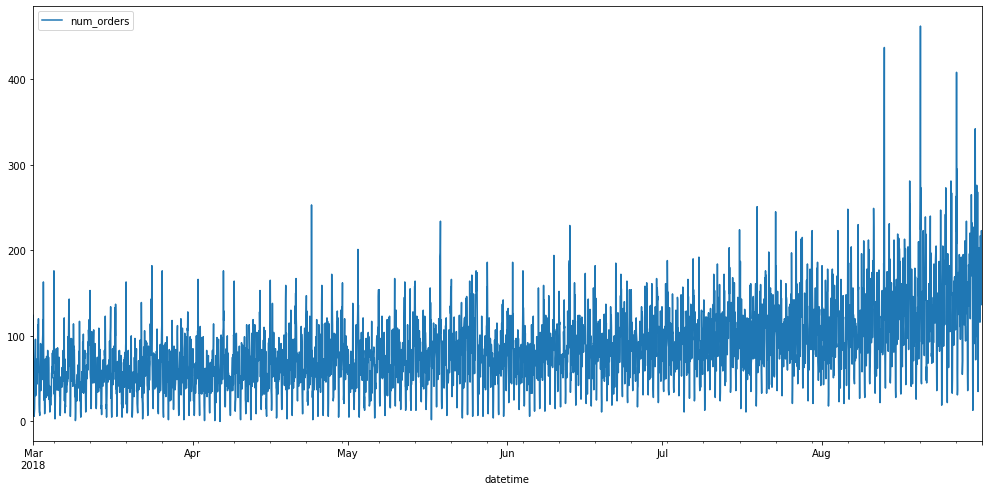

In [3]:
data_taxi = data_taxi .resample('1H').sum()
figsize = (17,8)
data_taxi.plot(figsize=figsize)

Рассмотрим данные по последней неделе.

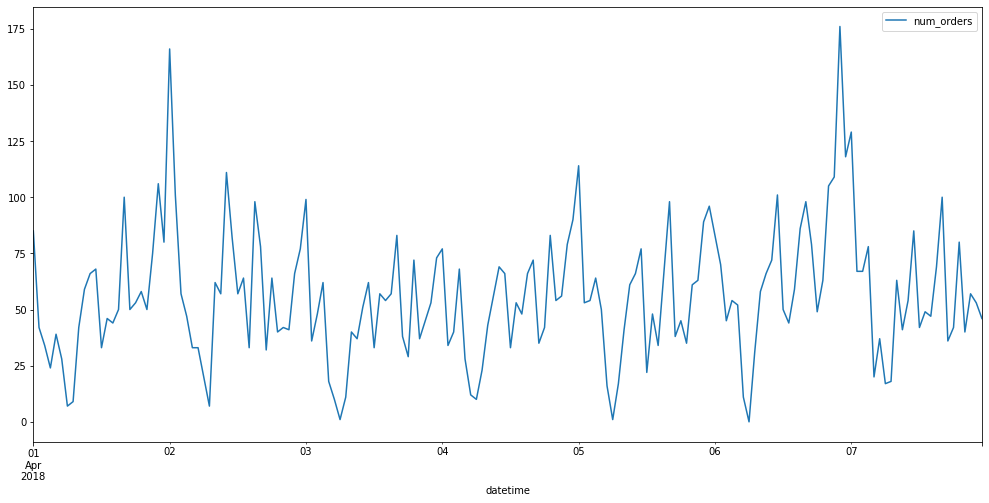

In [4]:
data_taxi['2018-04-01':'2018-04-07'].plot(figsize=figsize)

Изучим тернды и сезонность заказа такси.

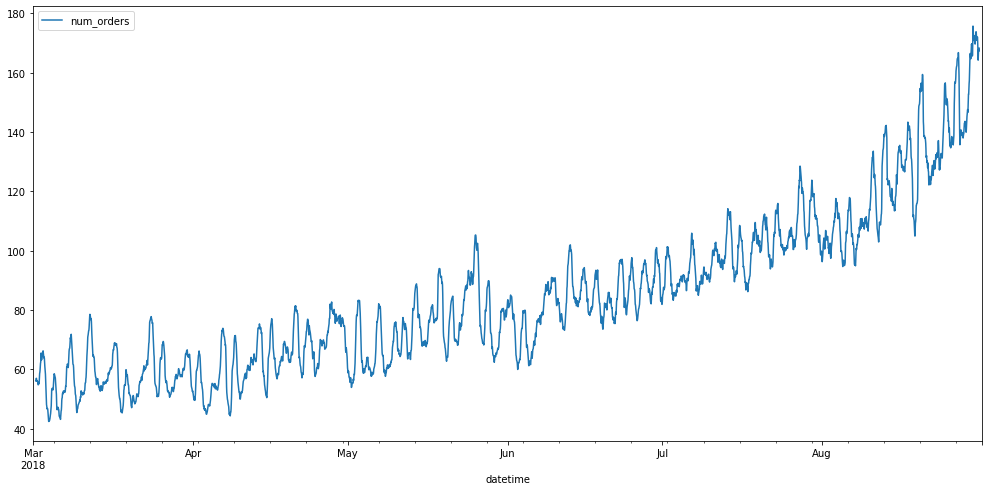

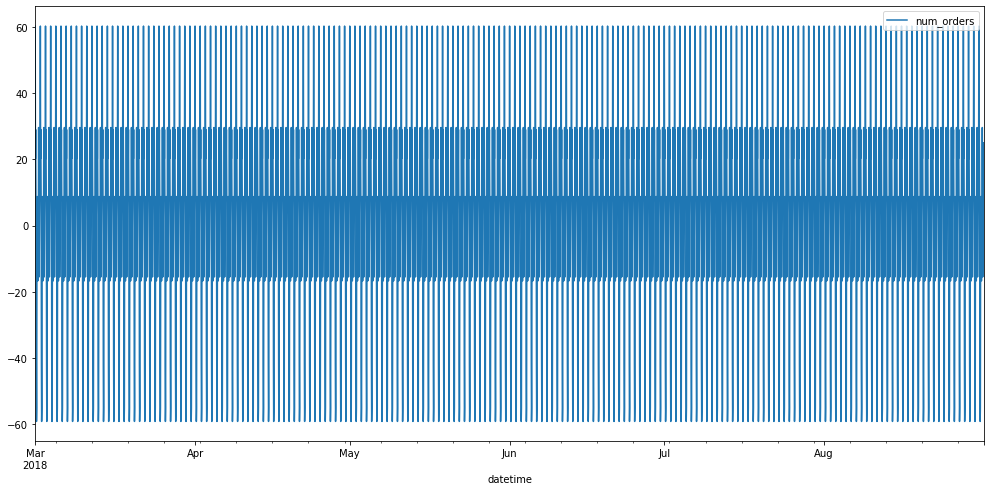

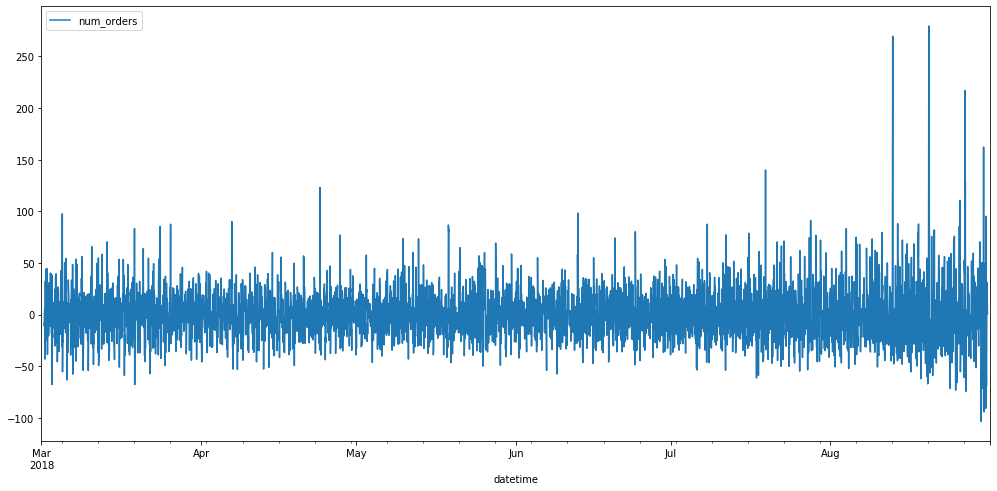

In [5]:
decomposed_data_taxi = seasonal_decompose(data_taxi)
decomposed_data_taxi.trend.plot(figsize=figsize)
decomposed_data_taxi.seasonal.plot(figsize=figsize)
decomposed_data_taxi.resid.plot(figsize=figsize)

Повторим разделение на сезонность и тренды за последнюю неделю.

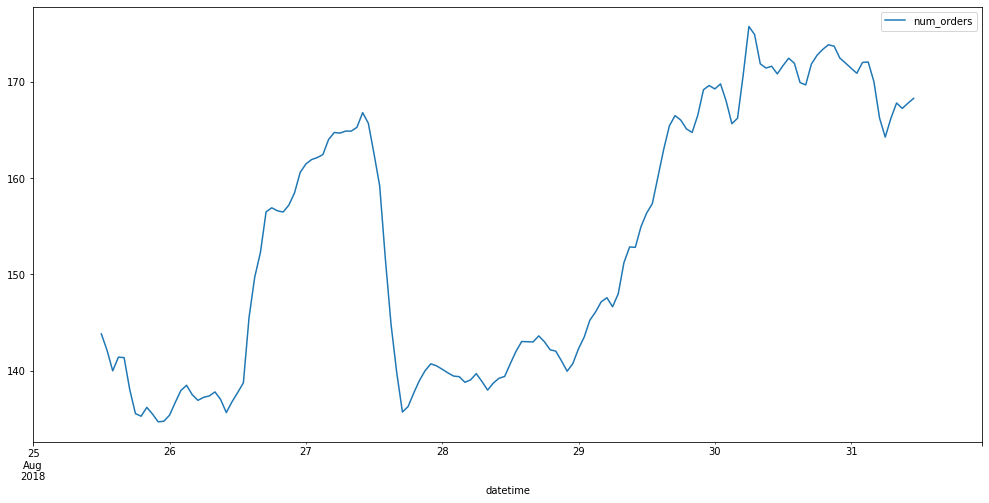

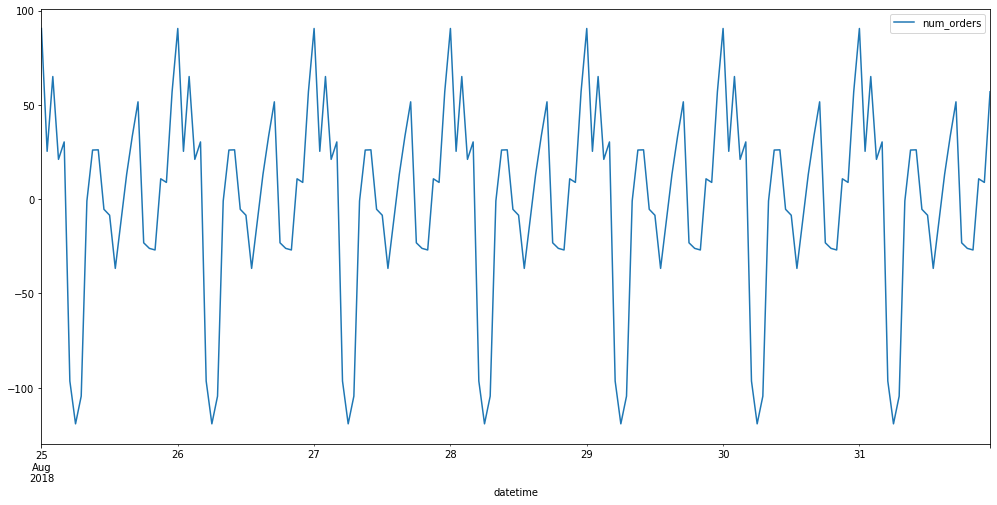

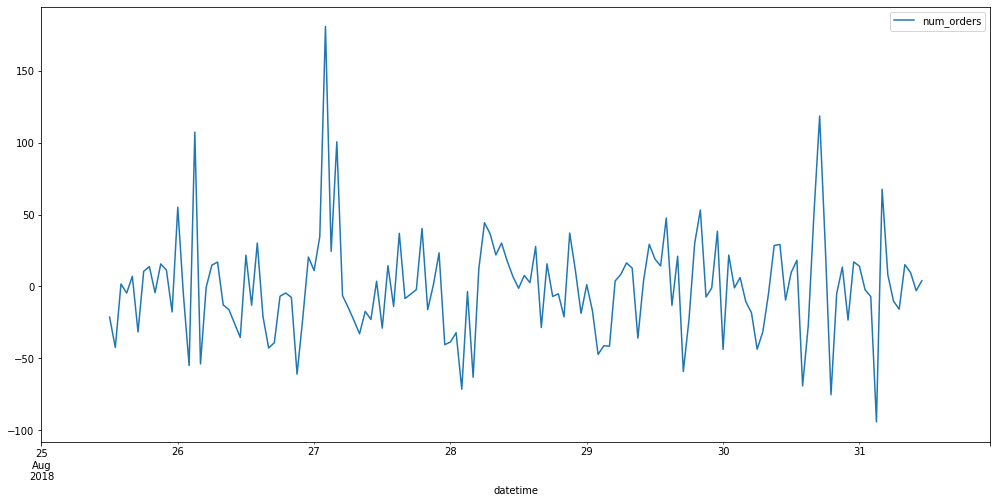

In [6]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-08-25':'2018-08-31'])
decomposed_data_taxi.trend.plot(figsize=figsize)
decomposed_data_taxi.seasonal.plot(figsize=figsize)
decomposed_data_taxi.resid.plot(figsize=figsize)

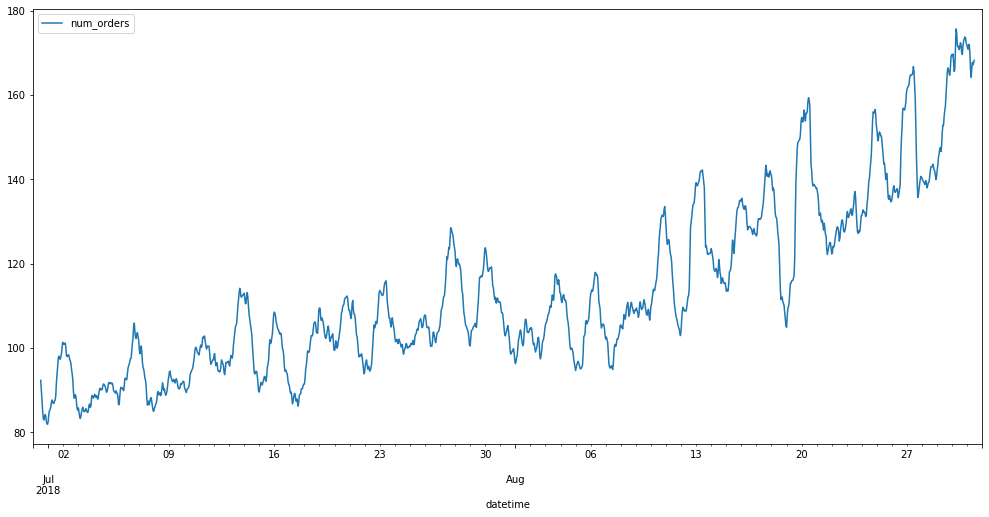

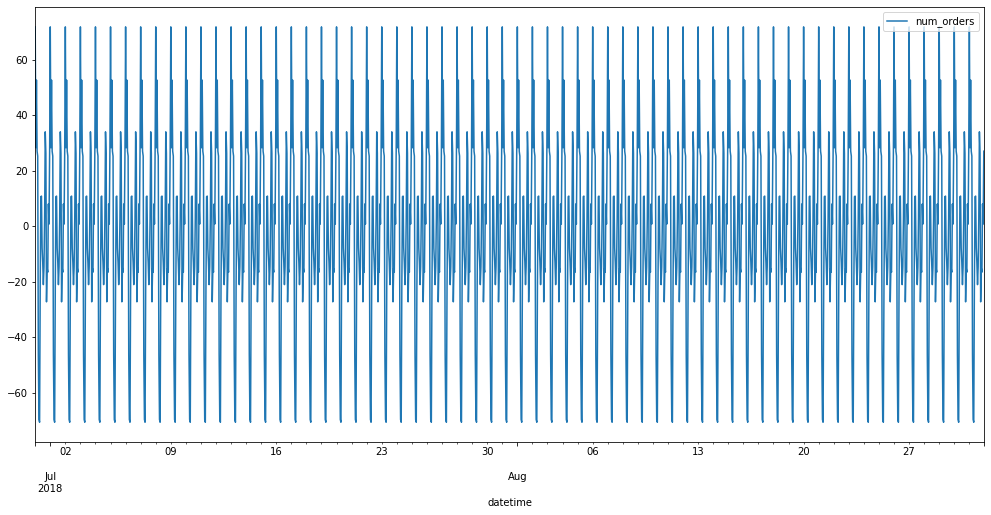

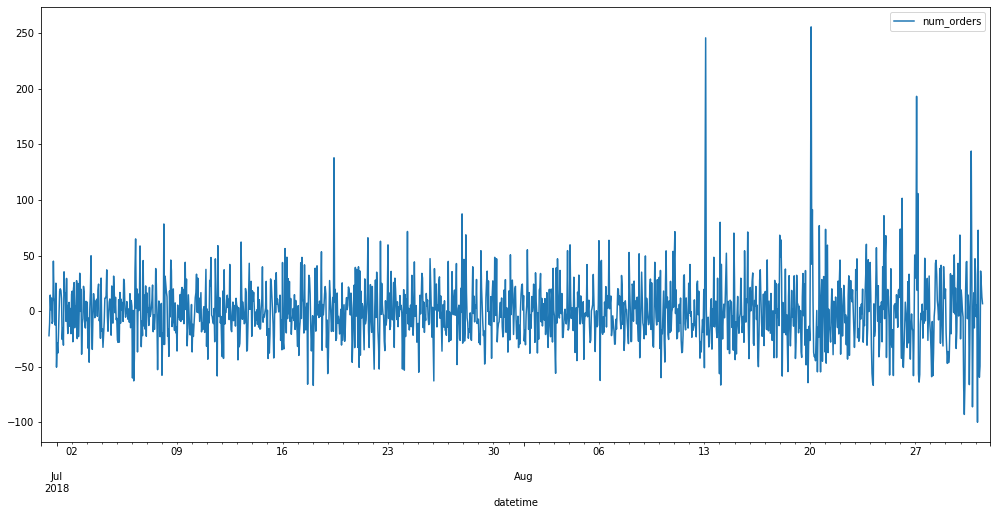

In [7]:
decomposed_data_taxi = seasonal_decompose(data_taxi['2018-06-30':'2018-08-31'])
decomposed_data_taxi.trend.plot(figsize=figsize)
decomposed_data_taxi.seasonal.plot(figsize=figsize)
decomposed_data_taxi.resid.plot(figsize=figsize)

Дисперсия ряда со временем увеличивается.<br>
По тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси.<br>
И каждый день видно, что такси требуются для ночных рейсов и по наступлению утра намечается спад вызовов такси.<br>

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени.
Это можно подтвердить критерием Дики-Фуллера.

Нулевая гипотеза гласит: "Временной ряд является нестацинарным".
Альтернативная: "Временной ряд стационарен"

In [8]:
p_value = adfuller(data_taxi['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.02894005140261368
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


При явном наличии тренда и сезонности, критерий Дики-Фуллера не значим.

Исследуем, какие признаки нам понадобится.

Так как видна ежедневная сезонность - то точно понадобится признак day.<br>
Тред показывает, что к концу недели и в середине идет увеличение заказов - добавим признак dayofweek.<br>
Из месяца в месяц данные отличаются и носят цикличный характер - добавим признак month.<br>
Для определения количество lag признаков найдем разницу в часах между максимальным пиком ночью и минимальным пиком в сезонном сегменте.<br>
Для ширины окна rolling_mean проверим, определим, какое окно в скользяще среднем лучше всего напоминает данные.<br>

In [9]:
decomposed_data_taxi_24h = seasonal_decompose(data_taxi['2018-08-30':'2018-08-31'])
max_lag = ((decomposed_data_taxi_24h.seasonal.idxmax() - decomposed_data_taxi_24h.seasonal.idxmin()) 
            // np.timedelta64(1, 'h'))[0]
max_lag

11

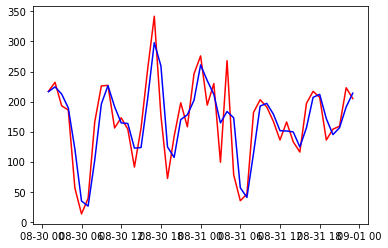

37.20937024517551


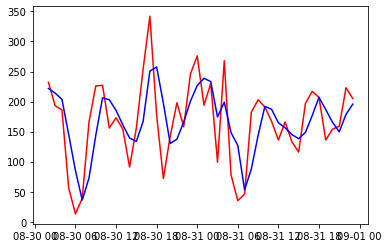

53.29049457074125


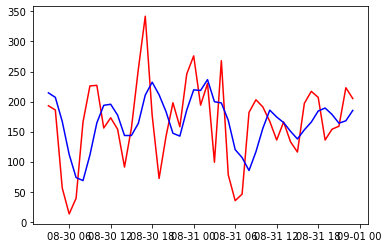

63.744498673306005


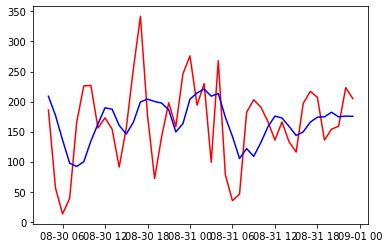

67.59614701230456


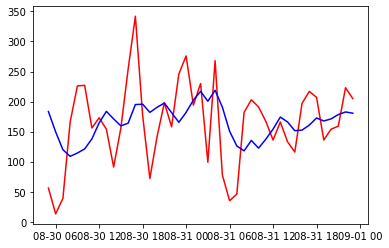

69.73090580801458


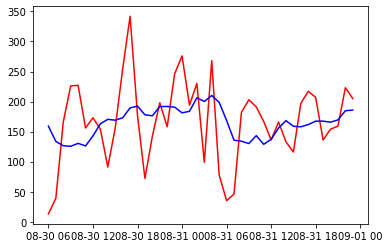

67.92390557450068


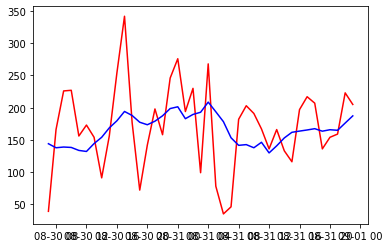

62.926871513977126


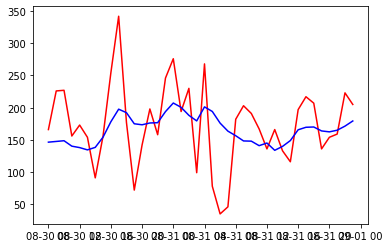

59.28822671627558


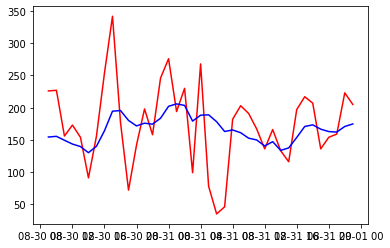

60.03829120033655


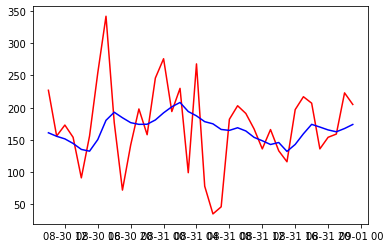

62.14800313100127


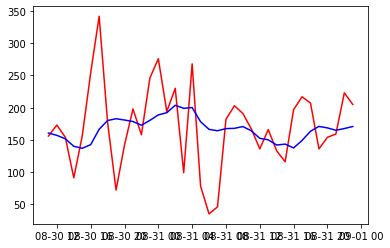

63.27369910554068


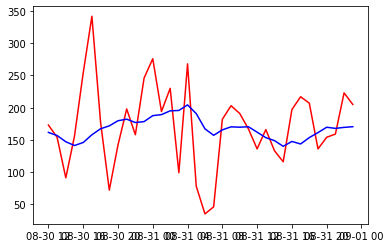

64.5242998632826


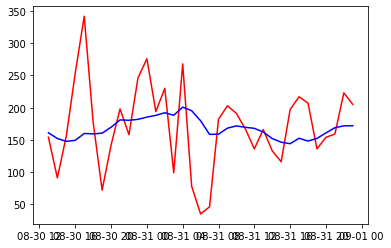

65.5193036785263


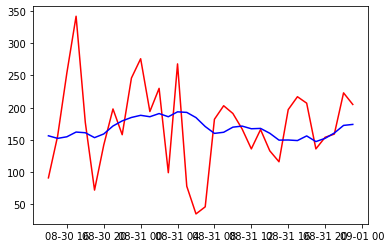

66.57033039492059


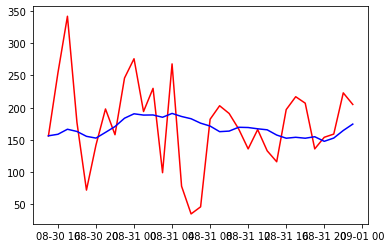

66.3901756391826


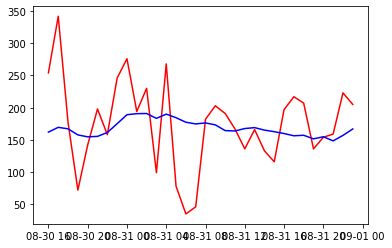

66.786833110948


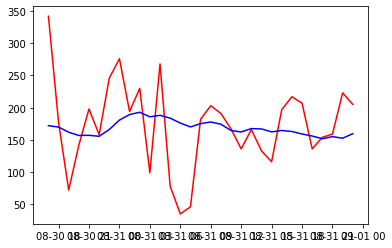

65.9555857159695


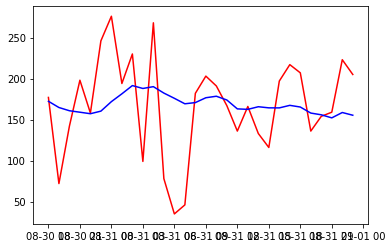

59.95063065843002


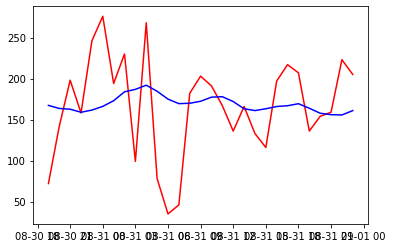

61.62310079608245


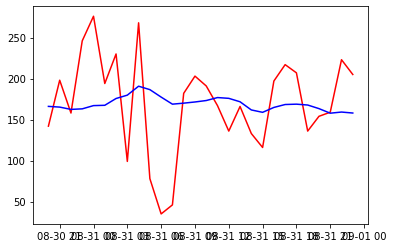

60.295350032185105


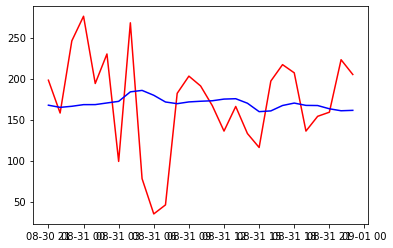

61.584824578009915


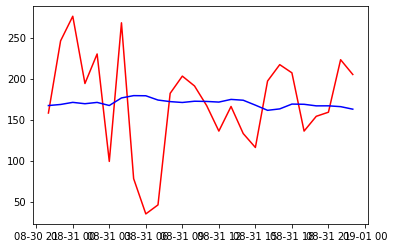

62.2411084136485


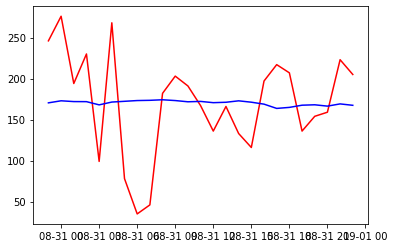

62.204006324173186


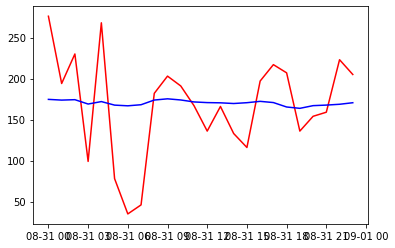

59.35472853951908


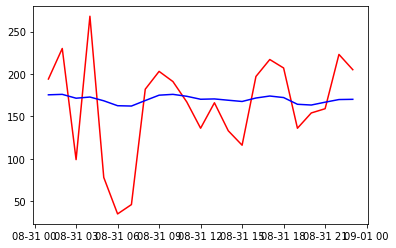

55.395072289503794


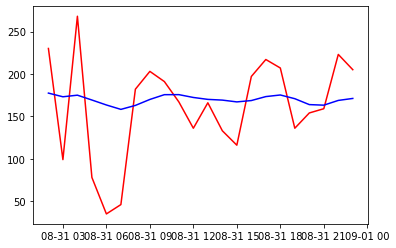

56.59878804647867


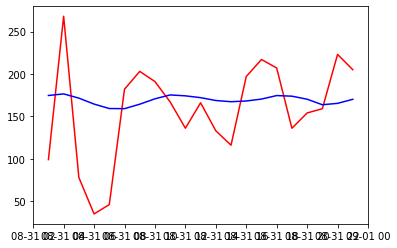

57.99764423770521


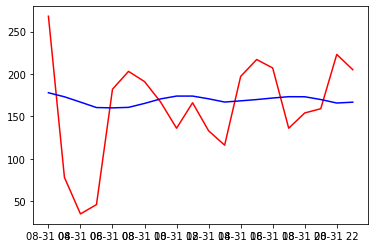

57.88077099016712


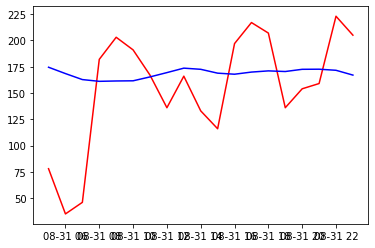

55.952374798698536


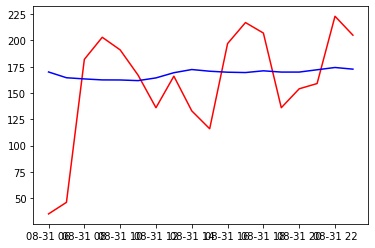

52.57135722880583


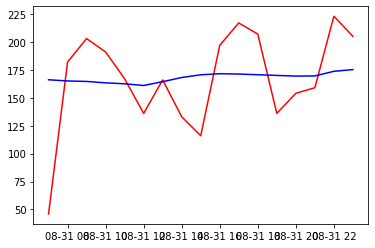

42.49692354782181


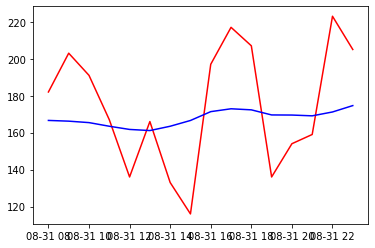

30.931430392629238


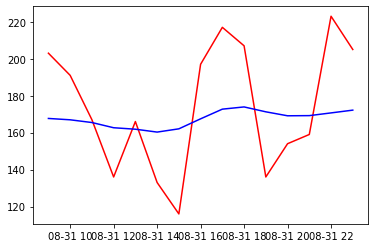

31.350481822389316


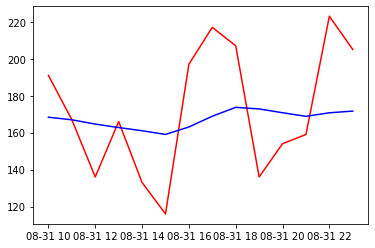

31.774131803954045


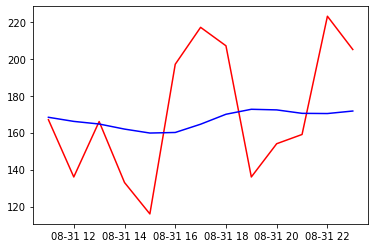

33.78557444177727


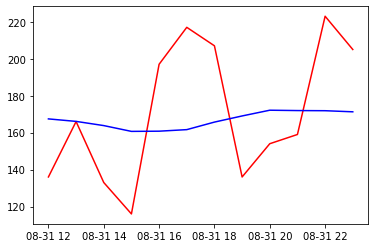

35.77340048315332


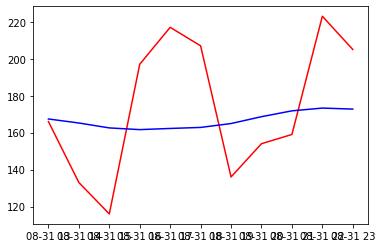

35.84313191905542


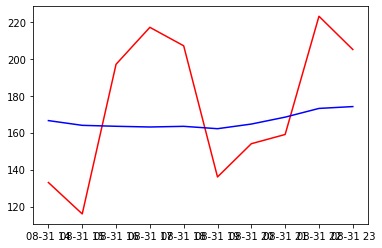

36.996836050019624


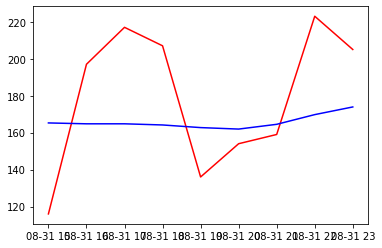

37.472419487167116


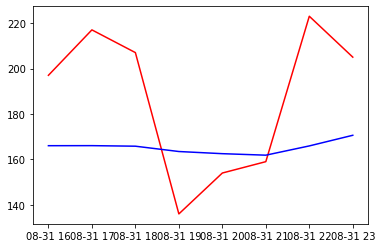

36.27573037059744


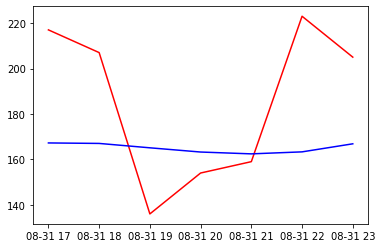

37.86404976996232


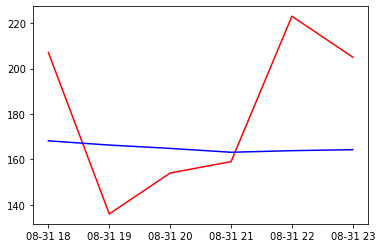

35.86913849604602


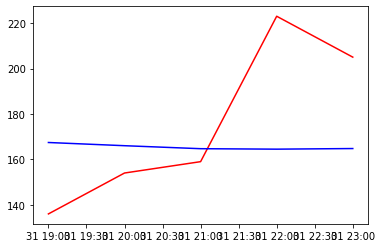

35.22933571671942


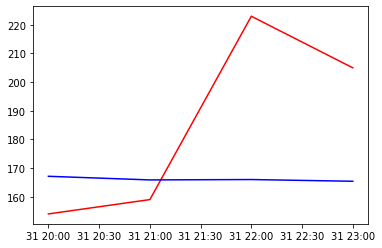

35.48519252996789


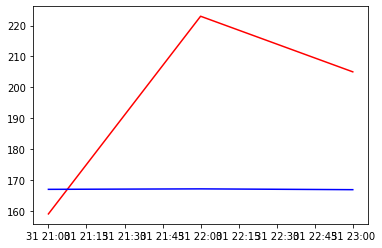

39.339261618971676


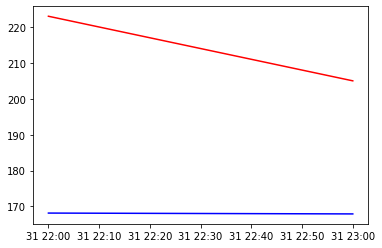

46.818502318507804


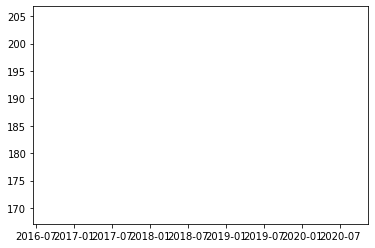

36.08333333333334


In [10]:
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data = data_taxi['2018-08-30':'2018-08-31'].copy()
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    index = data.index
    num_orders = data['num_orders']
    rolling_mean = data['rolling_mean']
    plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    plt.show()
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    print(RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE
    

In [11]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

Создадим признаки для обучения модели.

In [12]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

Использовать  TimeSeriesSplit вместо CV

In [13]:
data_taxi_copy = data_taxi.copy()
make_features(data_taxi,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data_taxi, shuffle=False, test_size=0.1, random_state=24072020)
train = train.dropna()

train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']
test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

Создадим cv выборку для временных рядов через TimeSeriesSplit.

In [14]:
def cv_time_series_rmse(regressor, data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_features = train.drop(target_column, axis=1)
        train_target = train[target_column]
        test_features = test.drop(target_column, axis=1)
        test_target = test[target_column]
        regressor.fit(train_features, train_target)
        RMSE += mean_squared_error(test_target, regressor.predict(test_features)) ** 0.5
    return RMSE / n_splits

In [15]:
cv_train_test_split = (train.shape[0] * 4 //5)
cv_splits = 3
cv_time_series_rmse(regressor=LinearRegression(), 
                    data=train, 
                    target_column='num_orders', 
                    n_splits=cv_splits, 
                    max_train_size=cv_train_test_split)

32.41065612403517

### Вывод по шагу 2

1. Данные были проанализированы.
2. Были выявлены тренды и сезонность.
3. Данные были подготовлены к обучению.
4. Создана функция для кроссвалидации временных рядов.

# 3. Обучение

Выберем следующие регрессоры для обучения модели:

1. LinearRegression
2. Ridge
3. DecisionTreeRegressor
4. ExtraTreesRegressor
5. CatBoostRegressor
6. LGBMRegressor
7. SARIMA

### 3.1 Линейная регрессия

In [16]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = cv_time_series_rmse(regressor=regressor, 
                                 data=train, 
                                 target_column='num_orders', 
                                 n_splits=cv_splits, 
                                 max_train_size=cv_train_test_split)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 32.41065612403517
CPU times: user 273 ms, sys: 302 ms, total: 575 ms
Wall time: 599 ms


In [17]:
%%time

regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = cv_time_series_rmse(regressor=pipeline, 
                                   data=train, 
                                   target_column='num_orders', 
                                   n_splits=cv_splits, 
                                   max_train_size=cv_train_test_split)
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 32.41065612403518
CPU times: user 224 ms, sys: 265 ms, total: 489 ms
Wall time: 415 ms


Масштабирование признаков не влияет. Не будем применять масштаб.

### 3.2 Регрессия Ridge

Проведем кроссвалидацию для следующих моделей в два шага:

1. С помощью GridSearchCV найдем лучший параметр.
2. Используя cv_time_series_rmse получить результат кроссвалидации на временном ряду.

In [18]:
%%time

regressor = Ridge()
hyperparams = [{'alpha':[0.1, 1, 10, 100, 1000],
                'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]


print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_R = clf.best_params_
print(best_params_R)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'alpha': 1000, 'solver': 'auto'}

Grid scores on development set:

30.909808 for {'alpha': 0.1, 'solver': 'auto'}
30.909808 for {'alpha': 0.1, 'solver': 'svd'}
30.909808 for {'alpha': 0.1, 'solver': 'cholesky'}
30.890897 for {'alpha': 0.1, 'solver': 'lsqr'}
30.909796 for {'alpha': 0.1, 'solver': 'sparse_cg'}
30.908621 for {'alpha': 1, 'solver': 'auto'}
30.908621 for {'alpha': 1, 'solver': 'svd'}
30.908621 for {'alpha': 1, 'solver': 'cholesky'}
30.891089 for {'alpha': 1, 'solver': 'lsqr'}
30.908811 for {'alpha': 1, 'solver': 'sparse_cg'}
30.897153 for {'alpha': 10, 'solver': 'auto'}
30.897153 for {'alpha': 10, 'solver': 'svd'}
30.897153 for {'alpha': 10, 'solver': 'cholesky'}
30.892991 for {'alpha': 10, 'solver': 'lsqr'}
30.897198 for {'alpha': 10, 'solver': 'sparse_cg'}
30.814620 for {'alpha': 100, 'solver': 'auto'}
30.814620 for {'alpha': 100, 'solver': 'svd'}
30.814620 for {'alpha':

In [19]:
%%time

regressor = Ridge()
regressor.set_params(**best_params_R)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_R = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
print('Mean RMSE from CV of Ridge =', cv_RMSE_R)

# Train for root_mean_squared_error

Mean RMSE from CV of Ridge = 32.69089465229889
CPU times: user 148 ms, sys: 128 ms, total: 276 ms
Wall time: 293 ms


### 3.3 Регрессия DecisionTreeRegressor

In [20]:
%%time

regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 21)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[24072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_DTR = clf.best_params_
print(best_params_DTR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 4, 'random_state': 24072020}

Grid scores on development set:

34.937298 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 24072020}
34.574343 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 24072020}
33.951422 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 24072020}
34.435832 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 24072020}
34.421884 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 24072020}
35.594545 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 24072020}
36.913948 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 24072020}
38.044826 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 24072020}
38.620901 for {'criterion': 'mse', 'max_depth': 10, 'random_state': 24072020}
41.542721 for {'criterion': 'mse', 'max_depth': 11, 'random_state': 24072020}
41.535954 for {'criterion': '

In [21]:
%%time

regressor = DecisionTreeRegressor()
regressor.set_params(**best_params_DTR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_DTR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Mean RMSE from CV of DecisionTreeRegressor =', cv_RMSE_DTR)

# Train for root_mean_squared_error

Mean RMSE from CV of DecisionTreeRegressor = 34.85566585061412
CPU times: user 44.5 ms, sys: 3.61 ms, total: 48.1 ms
Wall time: 44.6 ms


### 3.4 Регрессия ExtraTreesRegressor

In [22]:
%%time

regressor = ExtraTreesRegressor() 
hyperparams = [{'criterion':['mse'],
                'max_depth':max_depth_list, 
                'n_estimators':[x for x in range(100, 301, 50)],
                'random_state':[24072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_ETR = clf.best_params_
print(best_params_ETR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 18, 'n_estimators': 300, 'random_state': 24072020}

Grid scores on development set:

36.028981 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 100, 'random_state': 24072020}
35.965887 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 150, 'random_state': 24072020}
35.944322 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 200, 'random_state': 24072020}
35.906018 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 250, 'random_state': 24072020}
35.891637 for {'criterion': 'mse', 'max_depth': 2, 'n_estimators': 300, 'random_state': 24072020}
34.042403 for {'criterion': 'mse', 'max_depth': 3, 'n_estimators': 100, 'random_state': 24072020}
34.000451 for {'criterion': 'mse', 'max_depth': 3, 'n_estimators': 150, 'random_state': 24072020}
33.989181 for {'criterion': 'mse', 'max_depth': 3, 'n_estimators': 200, 'random_state': 24072

In [23]:
%%time

regressor = ExtraTreesRegressor()
regressor.set_params(**best_params_ETR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_ETR = cv_time_series_rmse(regressor=regressor, 
                                data=train, 
                                target_column='num_orders', 
                                n_splits=cv_splits, 
                                max_train_size=cv_train_test_split)
print('Mean RMSE from CV of ExtraTreesRegressor =', cv_RMSE_ETR)

# Train for root_mean_squared_error

Mean RMSE from CV of ExtraTreesRegressor = 30.915426384474472
CPU times: user 7.13 s, sys: 71.6 ms, total: 7.2 s
Wall time: 7.53 s


### 3.5 Регрессия CatBoostRegressor

In [24]:
%%time

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[24072020],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_CBR = clf.best_params_
print(best_params_CBR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 24072020, 'verbose': False}

Grid scores on development set:

30.754171 for {'learning_rate': 0.1, 'random_state': 24072020, 'verbose': False}
31.609142 for {'learning_rate': 0.2, 'random_state': 24072020, 'verbose': False}
31.758917 for {'learning_rate': 0.3, 'random_state': 24072020, 'verbose': False}
32.357651 for {'learning_rate': 0.4, 'random_state': 24072020, 'verbose': False}
32.845639 for {'learning_rate': 0.5, 'random_state': 24072020, 'verbose': False}

CPU times: user 4min 53s, sys: 37.7 s, total: 5min 31s
Wall time: 5min 51s


In [25]:
%%time

regressor = CatBoostRegressor()
regressor.set_params(**best_params_CBR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 31.86953198439115
CPU times: user 42.4 s, sys: 5.91 s, total: 48.3 s
Wall time: 52.1 s


Для сравнения с найденными параметрами, изучим как CatBoostRegressor находит RMSE без указания параметров.

In [26]:
%%time

regressor = CatBoostRegressor(verbose=False)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_no_params = cv_time_series_rmse(regressor=regressor, 
                                  data=train, 
                                  target_column='num_orders', 
                                  n_splits=cv_splits, 
                                  max_train_size=cv_train_test_split)
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_no_params)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 31.210211836552748
CPU times: user 41.5 s, sys: 6.12 s, total: 47.6 s
Wall time: 51.1 s


### 3.6 Регрессия LGBMRegressor

In [27]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'learning_rate':[x/10 for x in range(1, 6)],
                'random_state':[24072020]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(train_features, train_target)
print("Best parameters set found on development set:")
print()
best_params_LGBMR = clf.best_params_
print(best_params_LGBMR)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.1, 'random_state': 24072020}

Grid scores on development set:

30.418691 for {'learning_rate': 0.1, 'random_state': 24072020}
30.979906 for {'learning_rate': 0.2, 'random_state': 24072020}
31.130805 for {'learning_rate': 0.3, 'random_state': 24072020}
32.862301 for {'learning_rate': 0.4, 'random_state': 24072020}
33.149352 for {'learning_rate': 0.5, 'random_state': 24072020}

CPU times: user 18.9 s, sys: 152 ms, total: 19.1 s
Wall time: 19.2 s


In [28]:
%%time

regressor = LGBMRegressor()
regressor.set_params(**best_params_LGBMR)
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LGBMR = cv_time_series_rmse(regressor=regressor, 
                                    data=train, 
                                    target_column='num_orders', 
                                    n_splits=cv_splits, 
                                    max_train_size=cv_train_test_split)
print('Mean RMSE from CV of LGBMRegressor =', cv_RMSE_LGBMR)

# Train for root_mean_squared_error

Mean RMSE from CV of LGBMRegressor = 32.07158359383374
CPU times: user 3.54 s, sys: 36.4 ms, total: 3.57 s
Wall time: 3.6 s


### 3.7 Аналитическая модель SARIMA

Так как наш ряд нестационарен из-за причины тренда и обладает сезонностью в течении дня то для предсказания будующих значений нам подойдет алгоритм sARIMA. Так как наш временной ряд ресемплирован по часам, то сезонностью для него будет день или 24 часа.

Начнем с сезонного дифференцирования.

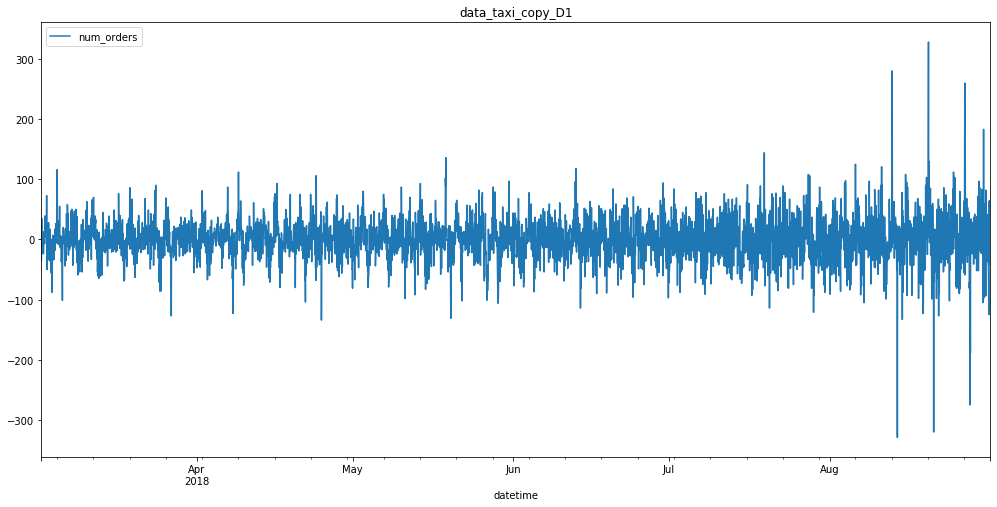

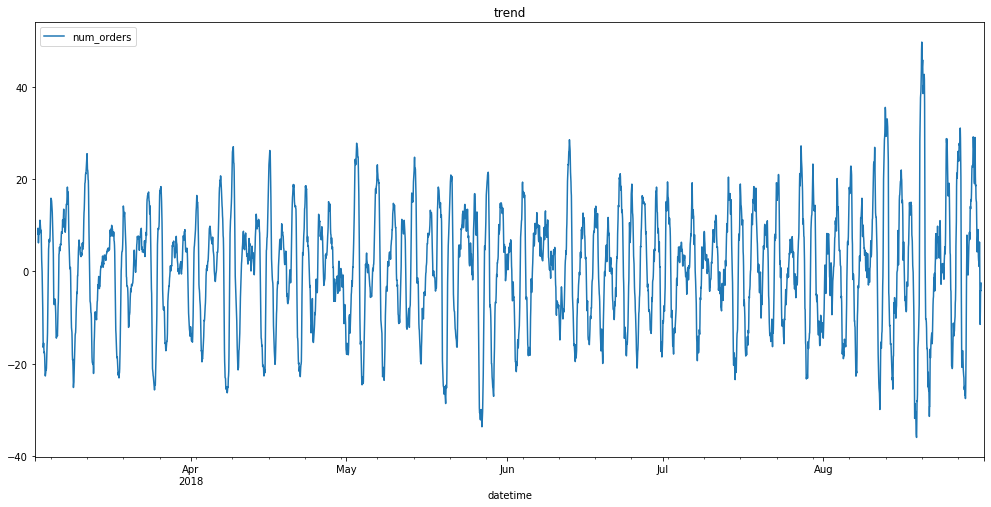

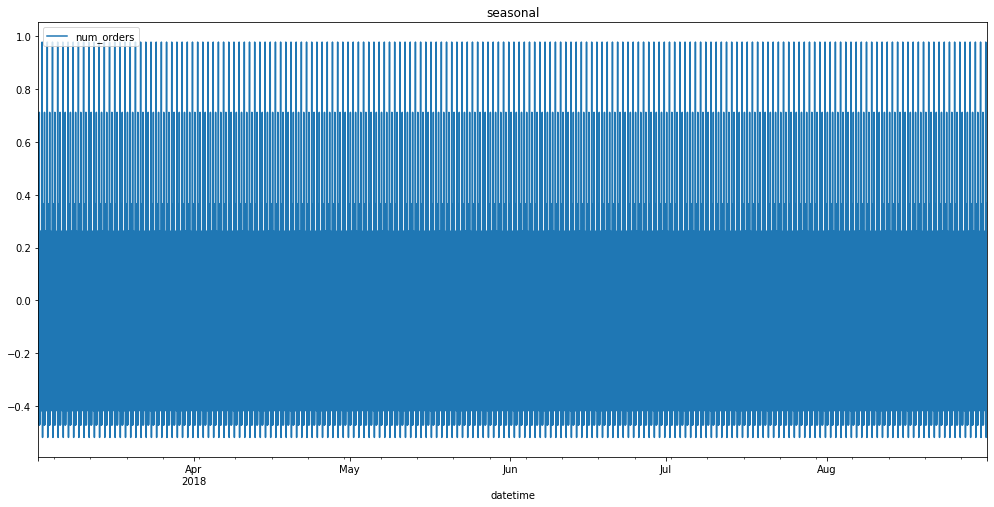

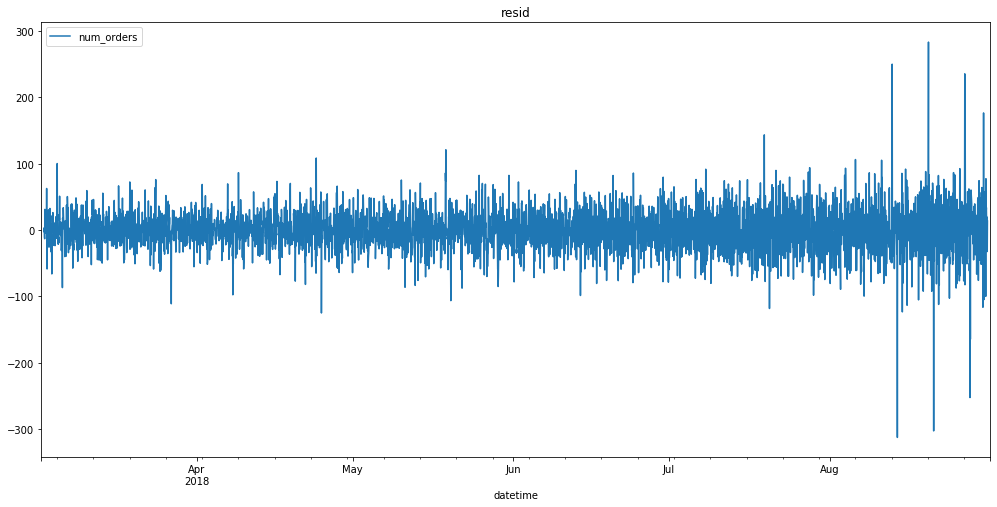

In [29]:
data_taxi_copy_D1 = data_taxi_copy - data_taxi_copy.shift(24)
data_taxi_copy_D1.dropna(inplace=True)
data_taxi_copy_D1.plot(figsize=figsize, title='data_taxi_copy_D1')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_D1)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

Проверим стационарность после применения первого дифференцирования.

In [30]:
p_value = adfuller(data_taxi_copy_D1['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 6.430826940726686e-29
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Если изучить тренд, то видно, что он напоминает стационарный ряд, но сильно колеблится. Проверим дифференцирование на предудущем дне.

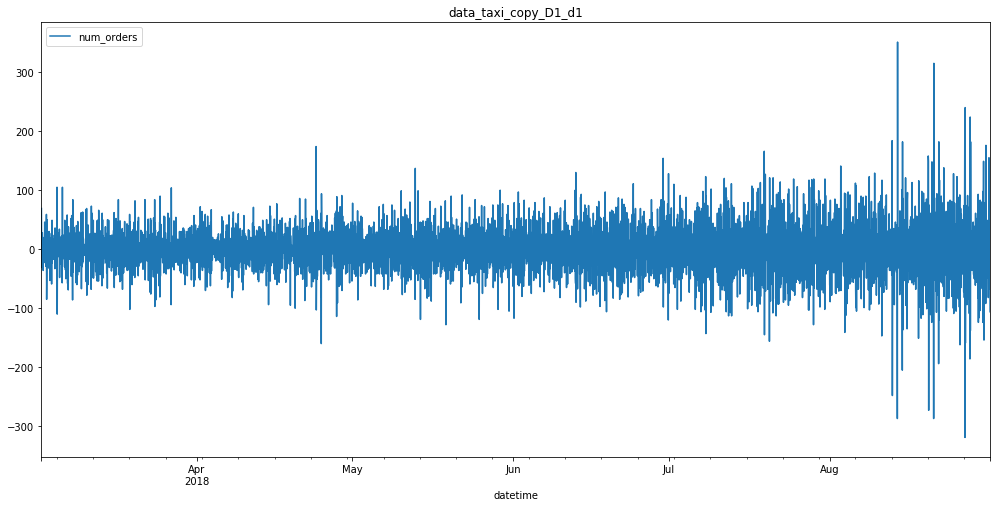

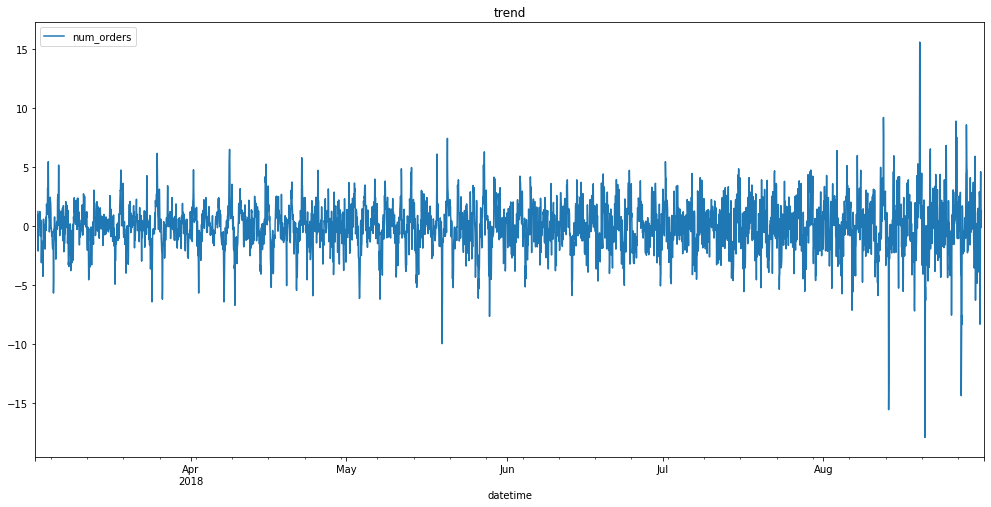

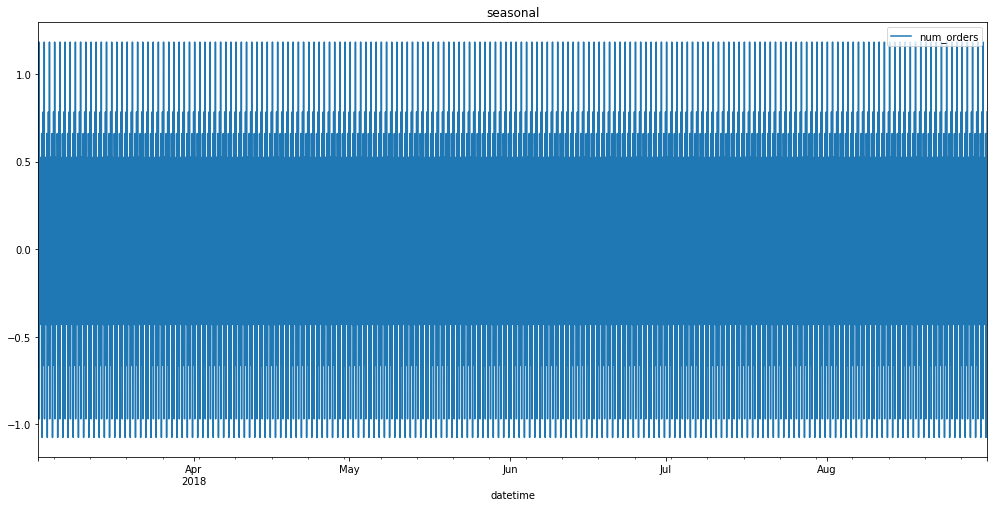

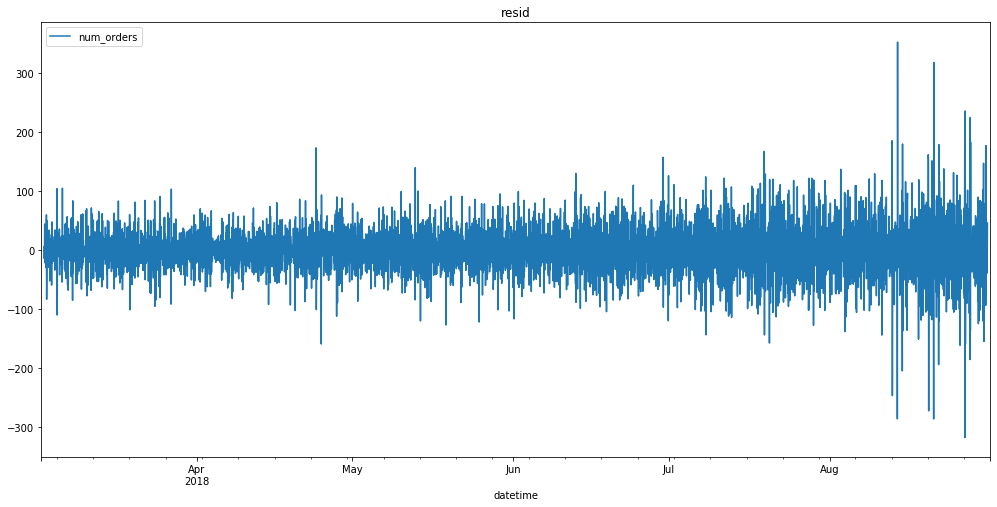

In [31]:
data_taxi_copy_D1_d1 = data_taxi_copy_D1 - data_taxi_copy_D1.shift(1)
data_taxi_copy_D1_d1.dropna(inplace=True)
data_taxi_copy_D1_d1.plot(figsize=figsize, title='data_taxi_copy_D1_d1')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_D1_d1)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

In [32]:
p_value = adfuller(data_taxi_copy_D1_d1['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 0.0
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Разброс тренда изменился. Повторим дифференцирование.

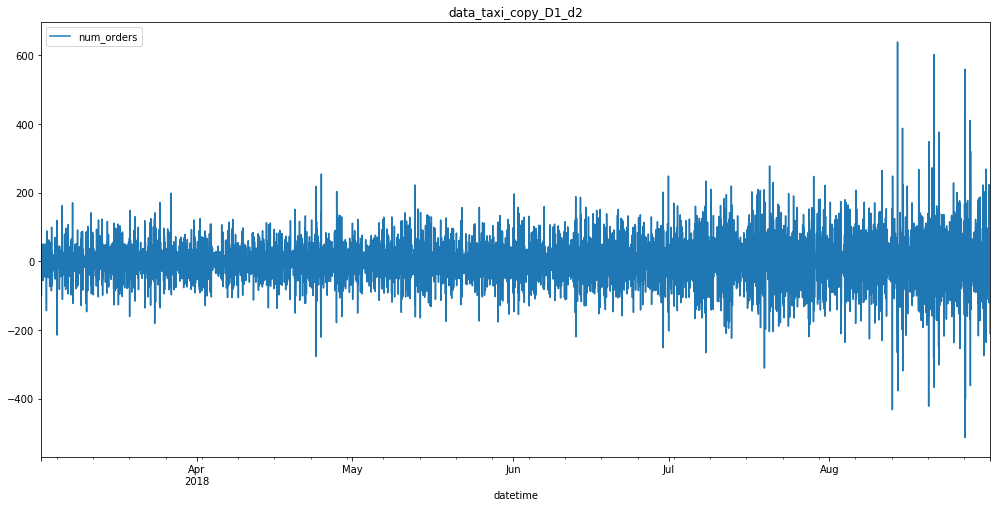

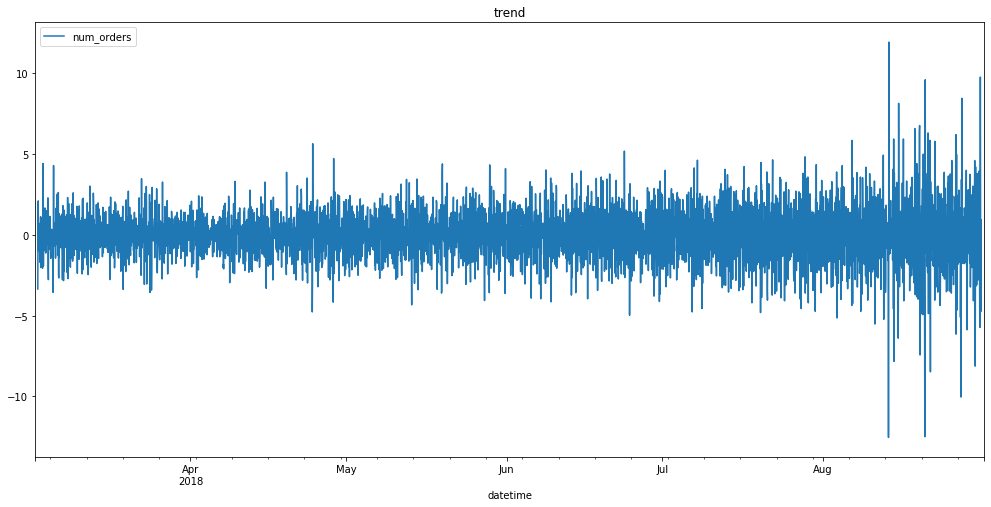

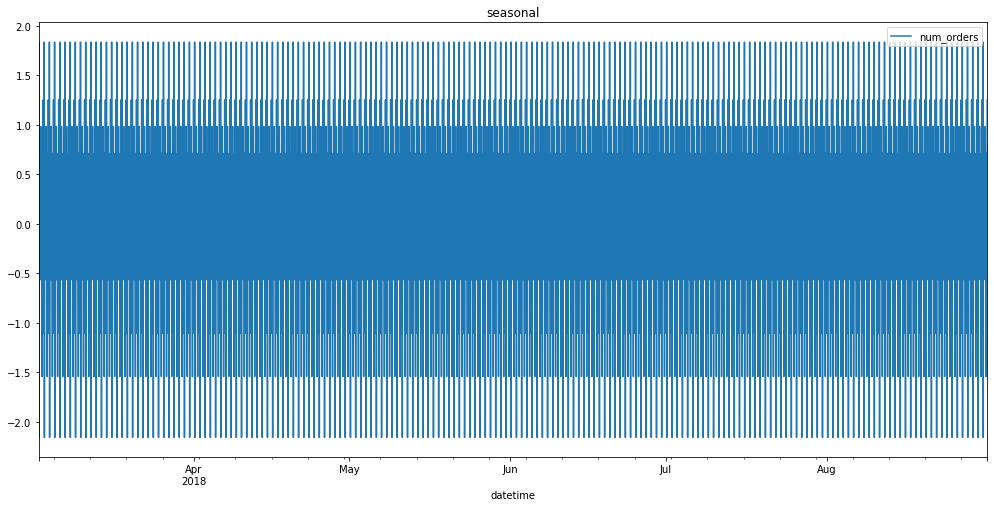

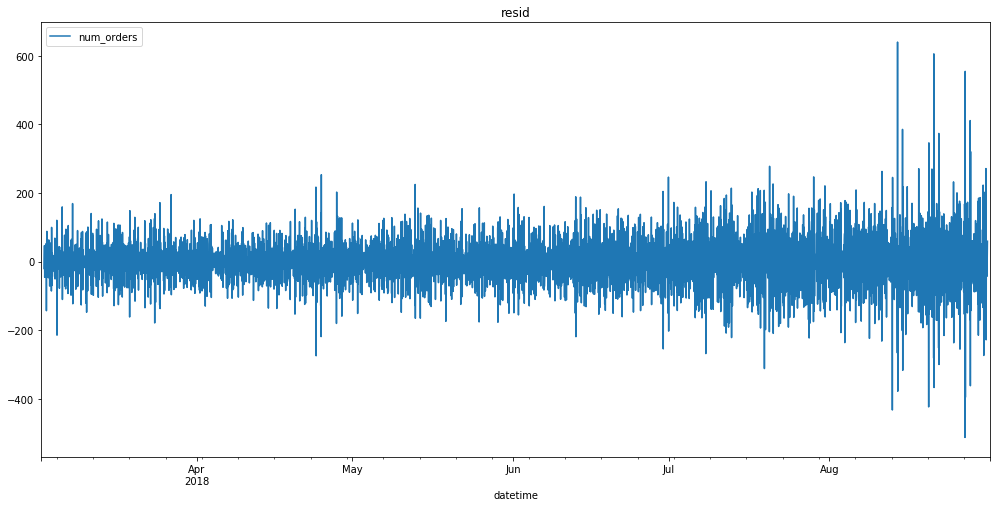

In [33]:
data_taxi_copy_D1_d2 = data_taxi_copy_D1_d1 - data_taxi_copy_D1_d1.shift(1)
data_taxi_copy_D1_d2.dropna(inplace=True)
data_taxi_copy_D1_d2.plot(figsize=figsize, title='data_taxi_copy_D1_d2')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_D1_d2)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

In [34]:
p_value = adfuller(data_taxi_copy_D1_d2['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 6.405733716119246e-30
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Разброс тренда изменился. Повторим дифференцирование.

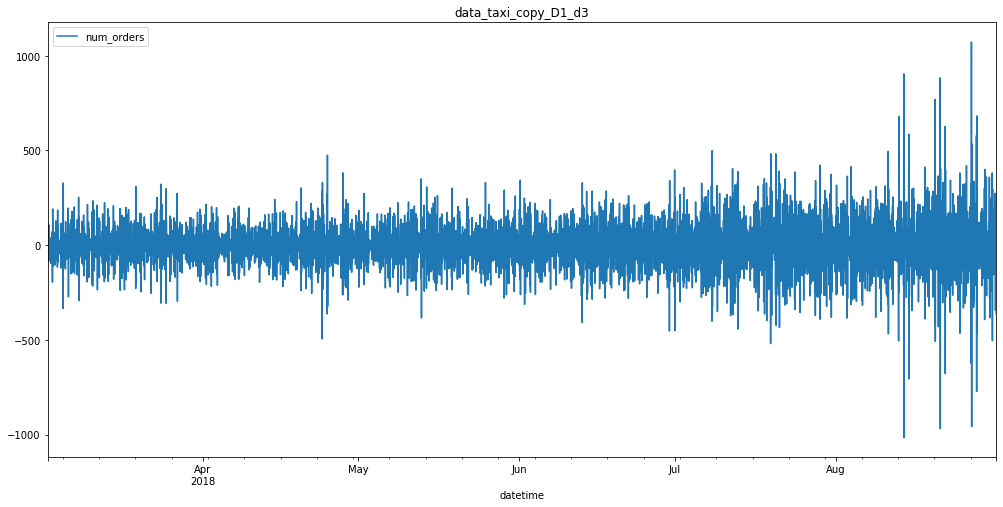

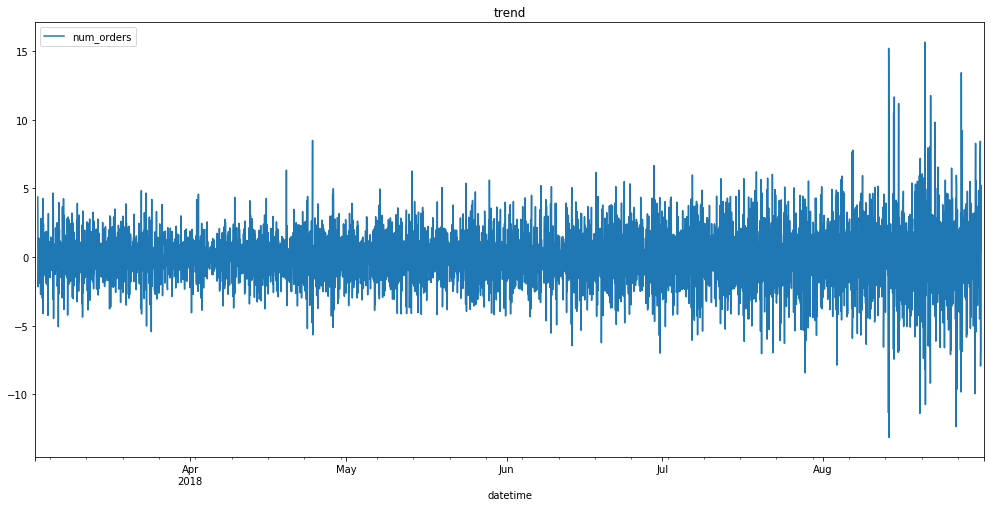

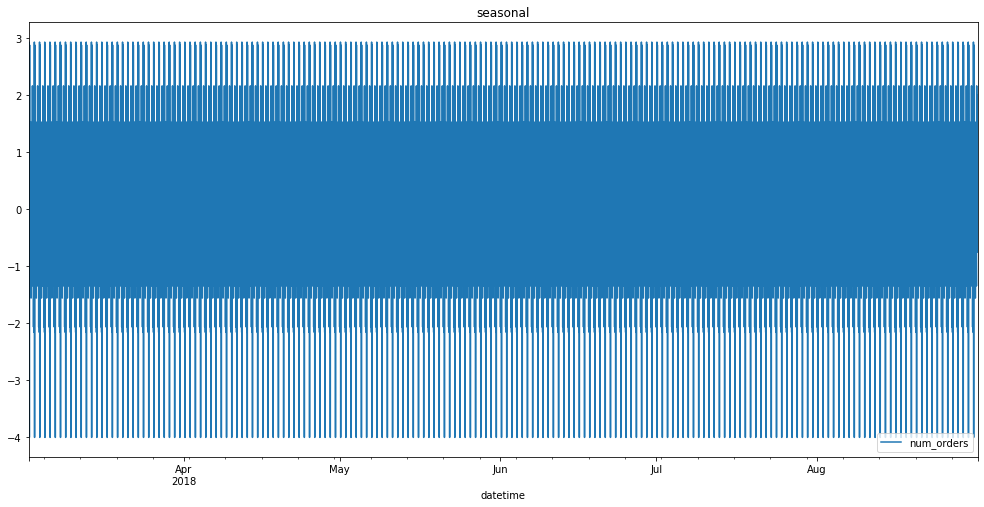

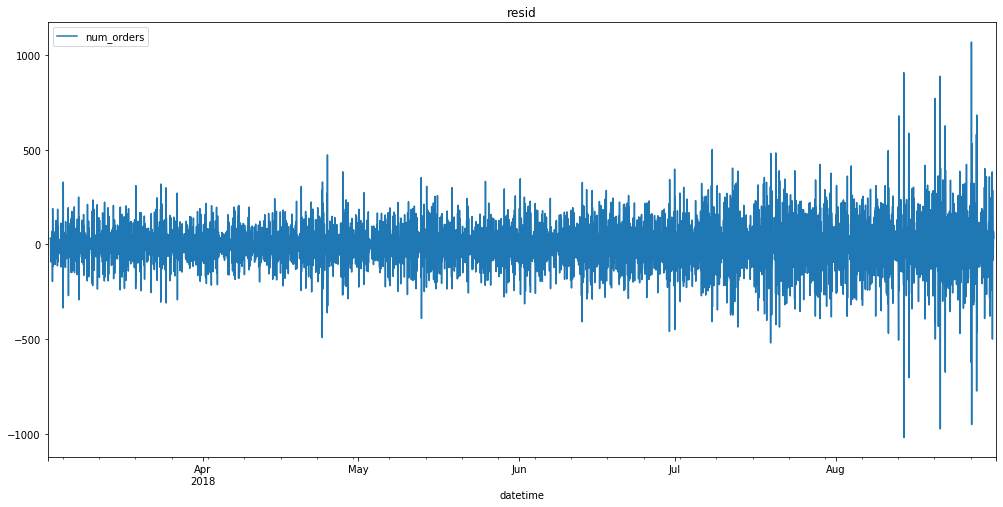

In [35]:
data_taxi_copy_D1_d3 = data_taxi_copy_D1_d2 - data_taxi_copy_D1_d2.shift(1)
data_taxi_copy_D1_d3.dropna(inplace=True)
data_taxi_copy_D1_d3.plot(figsize=figsize, title='data_taxi_copy_D1_d3')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_D1_d3)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

In [36]:
p_value = adfuller(data_taxi_copy_D1_d3['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 0.0
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Разброс тренда ухудшился. Нужно применить функцию логарифмирования к начальным данным и повторить шиги дифференцирования.

In [37]:
data_taxi_copy['num_orders']

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4416, dtype: int64

In [38]:
data_taxi_copy_BC = data_taxi_copy.copy()
data_taxi_copy_BC['num_orders'] = pt.fit_transform(data_taxi_copy_BC)
data_taxi_copy_BC

num_orders
datetime                       
2018-03-01 00:00:00    0.926262
2018-03-01 01:00:00    0.147722
2018-03-01 02:00:00   -0.174203
2018-03-01 03:00:00   -0.296688
2018-03-01 04:00:00   -0.930597
...                         ...
2018-08-31 19:00:00    1.140345
2018-08-31 20:00:00    1.444579
2018-08-31 21:00:00    1.525906
2018-08-31 22:00:00    2.471952
2018-08-31 23:00:00    2.221349

[4416 rows x 1 columns]

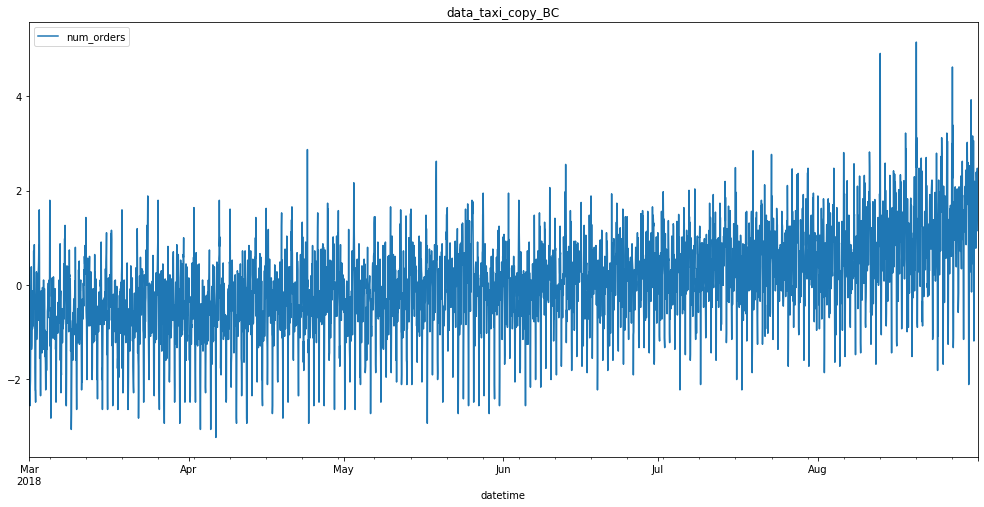

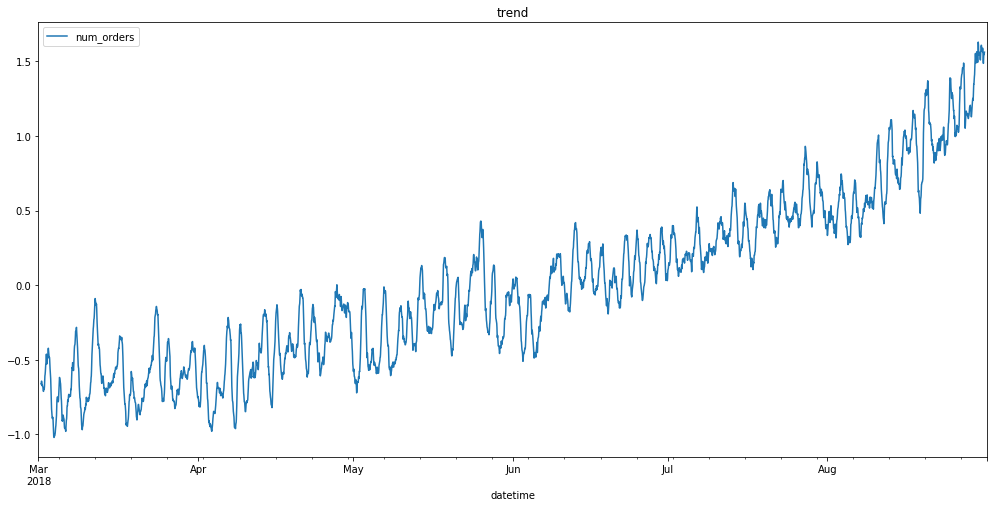

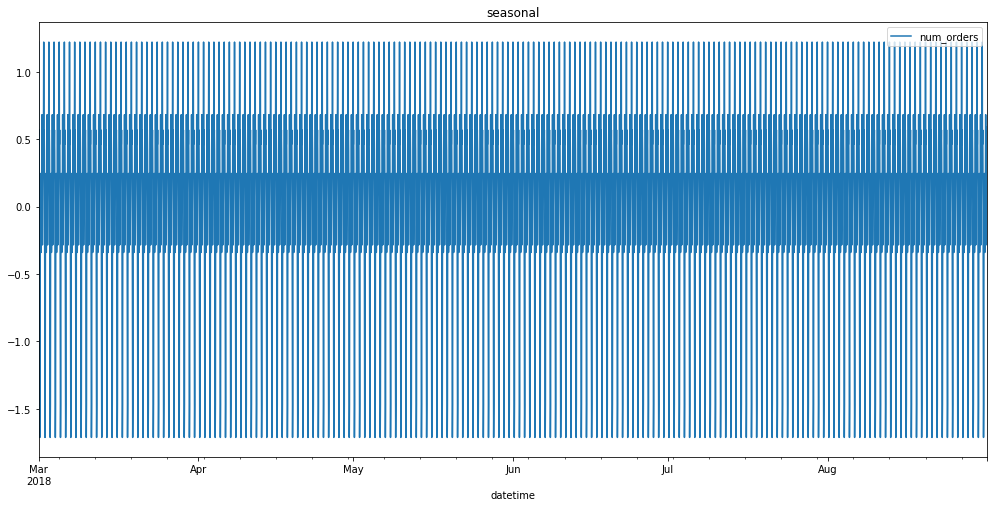

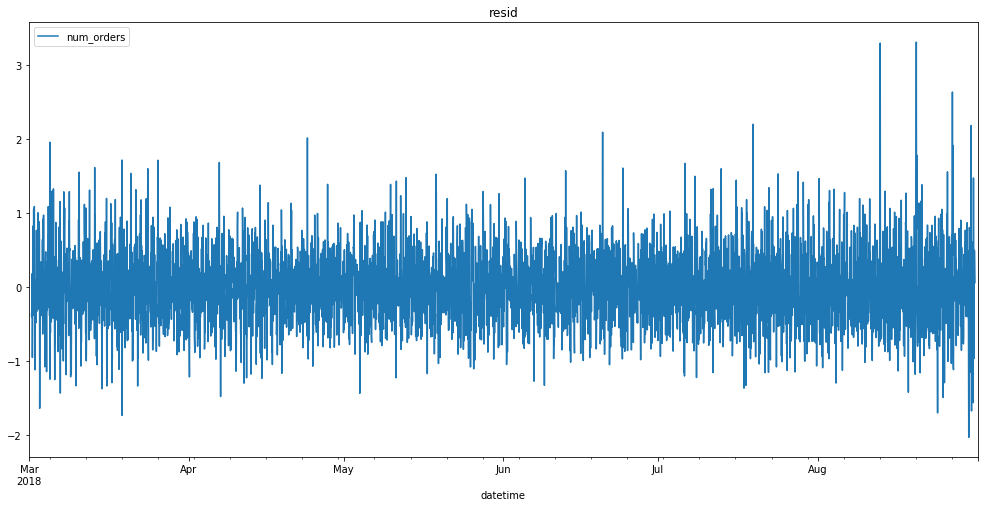

In [39]:
data_taxi_copy_BC.plot(figsize=figsize, title='data_taxi_copy_BC')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_BC)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

In [40]:
p_value = adfuller(data_taxi_copy_BC['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 0.01367598529349901
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


Проведем все трансформации с прологарифмированным рядом.

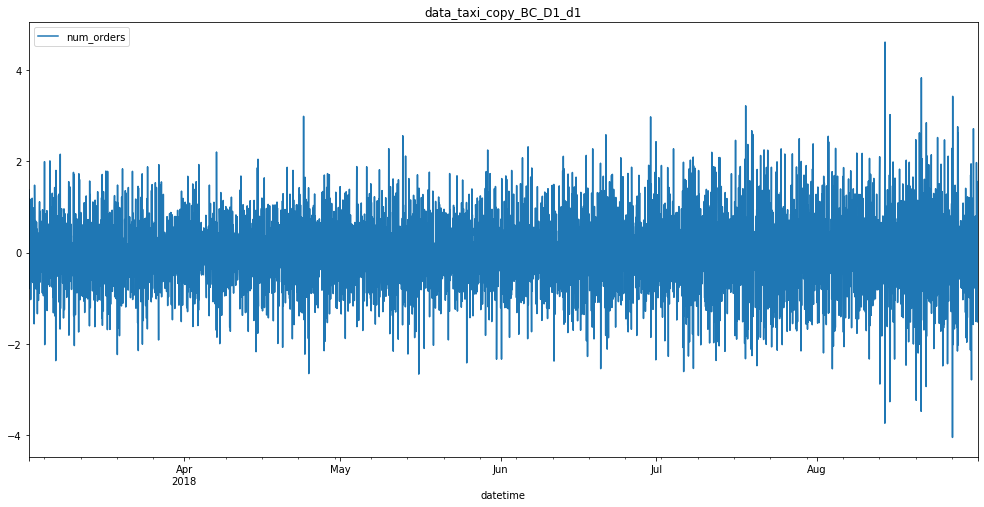

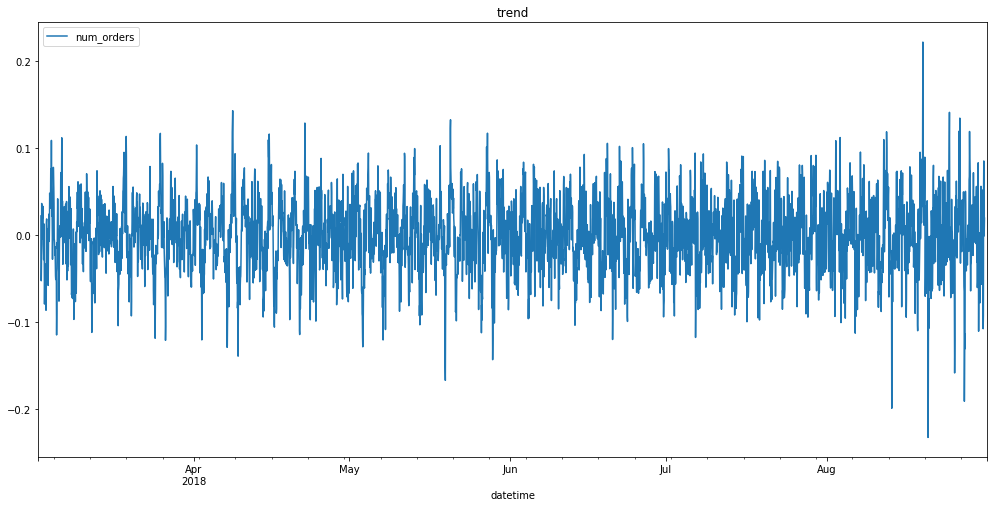

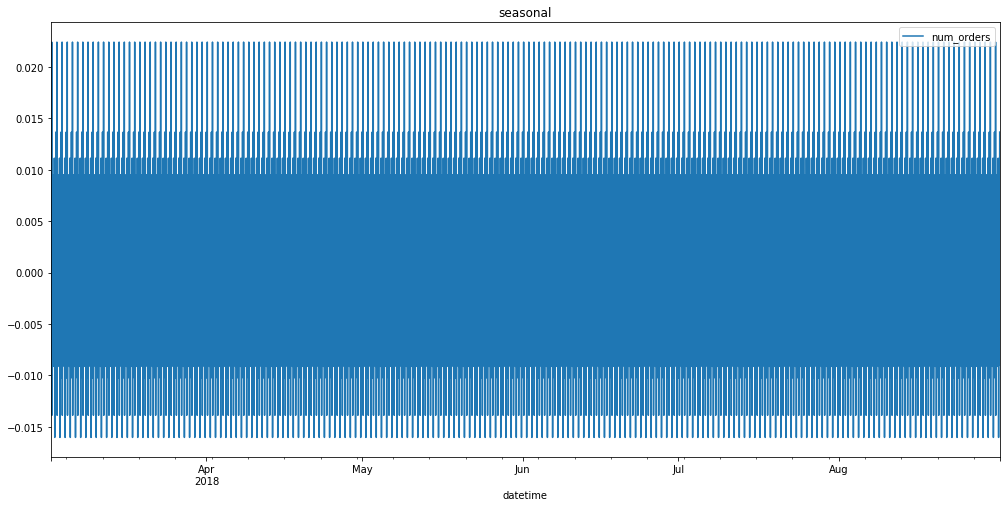

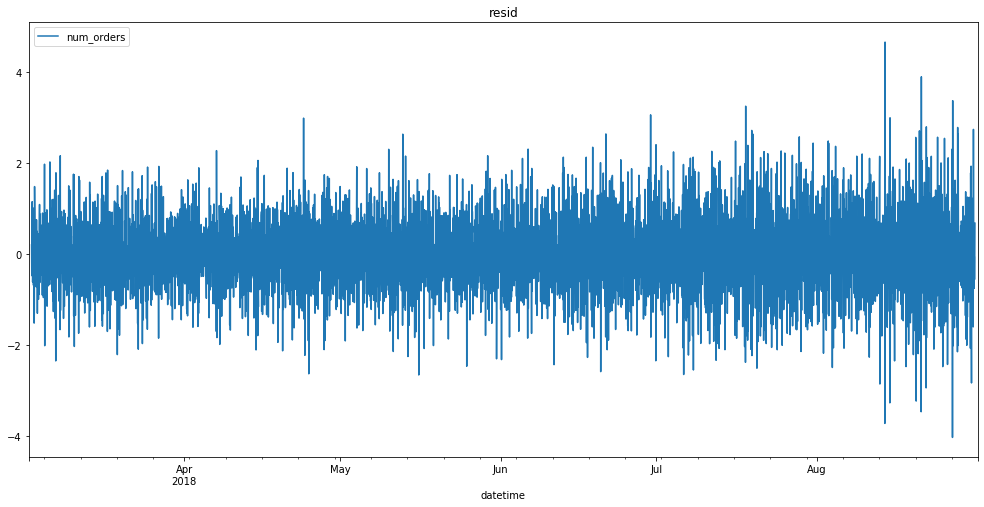

In [41]:
data_taxi_copy_BC_D1 = data_taxi_copy_BC - data_taxi_copy_BC.shift(24)
data_taxi_copy_BC_D1_d1 = data_taxi_copy_BC_D1 - data_taxi_copy_BC_D1.shift(1)
data_taxi_copy_BC_D1_d1.dropna(inplace=True)
data_taxi_copy_BC_D1_d1.plot(figsize=figsize, title='data_taxi_copy_BC_D1_d1')
decomposed_data_taxi = seasonal_decompose(data_taxi_copy_BC_D1_d1)
decomposed_data_taxi.trend.plot(figsize=figsize, title='trend')
decomposed_data_taxi.seasonal.plot(figsize=figsize, title='seasonal')
decomposed_data_taxi.resid.plot(figsize=figsize, title='resid')

In [42]:
p_value = adfuller(data_taxi_copy_BC_D1_d1['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд стационарен по критерию Дики-Фуллера')

P = 0.0
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


В ходе работы над стационарным рядом тренд стал мало изменяться, значит можно считаться с критерием Дики-Фуллера.

Мы нашли два параметра из 6 для SARIMA модели: D=1, d=2.

Найдем остальные по результатам авто и частичной корреляции.

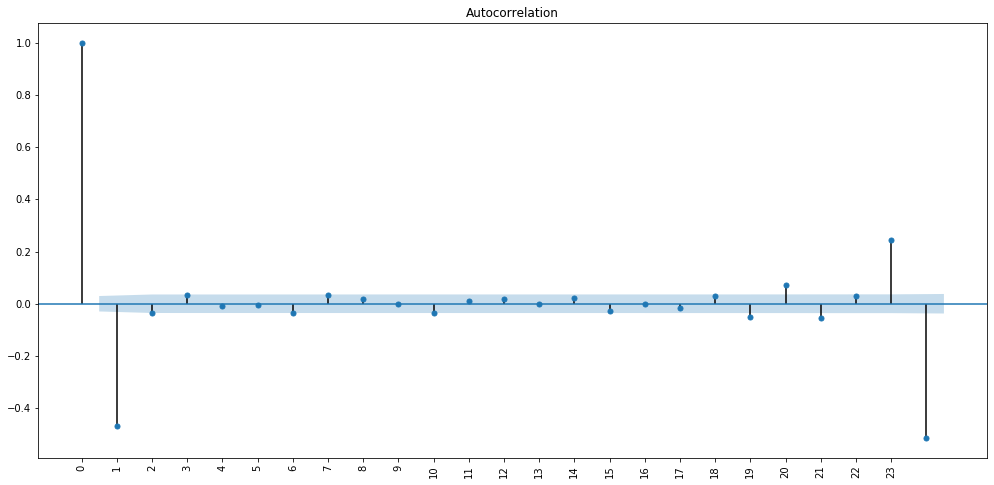

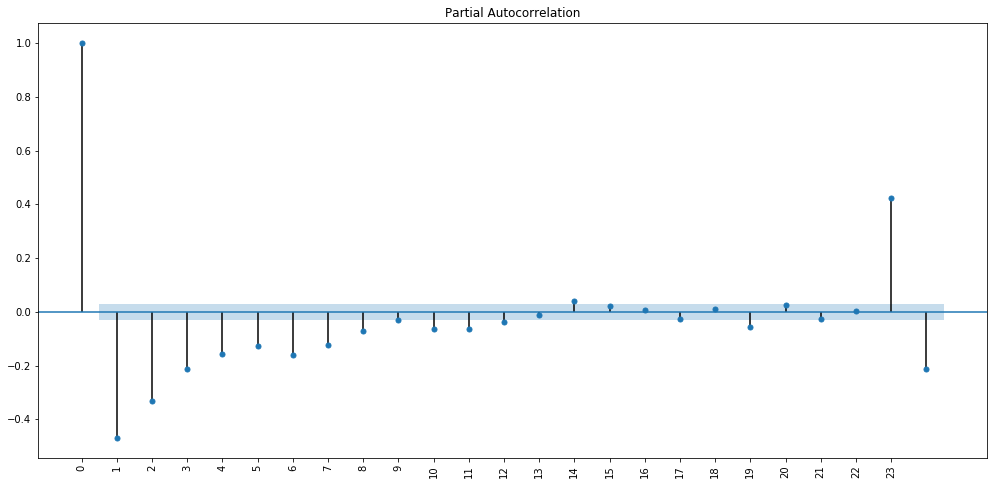

In [43]:
time_list = data_taxi_copy_BC_D1_d1['num_orders']
lags = 24
plt.figure(figsize=figsize)
plt.xticks(list(range(lags)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)
plt.show()
plt.figure(figsize=figsize)
plt.xticks(list(range(lags)),rotation=90)
ax = plt.subplot(111)
pacf = plot_pacf(time_list, lags=lags, ax=ax)

Параметр q=2 и параметр p=8. Найдем сезонные параметры.

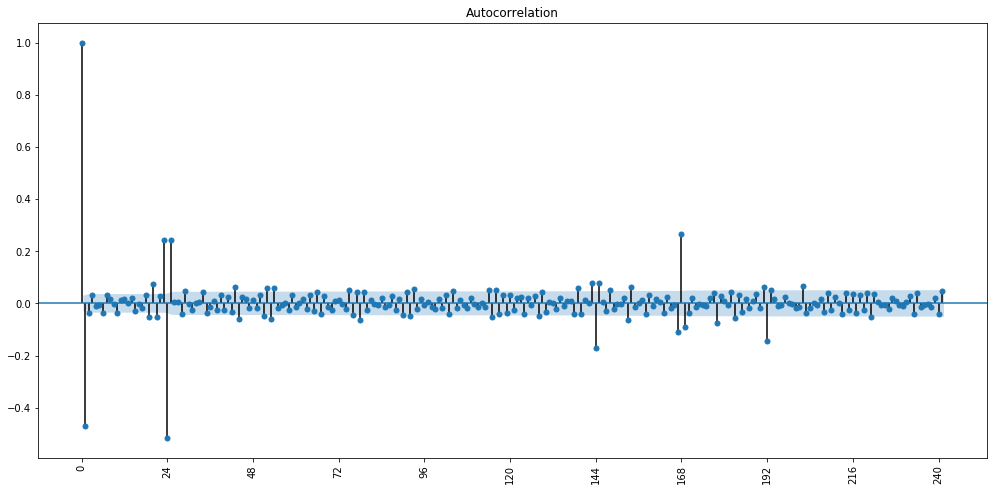

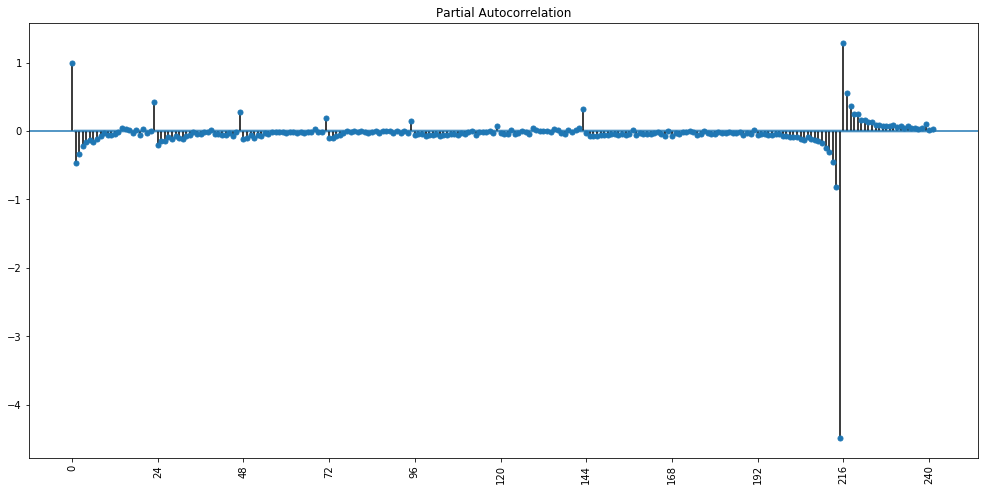

In [44]:
lags = 241
plt.figure(figsize=figsize)
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)
plt.show()
plt.figure(figsize=figsize)
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
pacf = plot_pacf(time_list, lags=lags, ax=ax)

Параметр Q=1 и P=6. Теперь преступим к перебору значений для поиска лучшей модели SARIMA.

Исходя из того, что всего сочетаний с текущим набором параметров будет 120 и высоких параметрах p и P, модель может обучаться практически бесконечно, было принято решение провести сочетания параметров не выше 2го порядка. Расходящиеся модели будут пропускаться при долгой обработке. Оценивающим критерием будет AIC.

In [45]:
d=1
D=1
s=24
best_model = ''
best_aic = float('inf')

params = [(0, 0, 0, 0),
          (1, 1, 1, 1),
          (2, 1, 1, 1),
          (1, 1, 2, 1)]

In [46]:
%%time

result = []
best_model = 0
best_aic = float('inf')
best_param = 0

for param in params:
    try:
        model = sarimax.SARIMAX(data_taxi_copy_BC['num_orders'], 
                       order=(param[0], d, param[1]), 
                       seasonal_order=(param[2], D, param[3],s)).fit(disp=-1)
        aic = model.aic
        print([param, aic])
        result.append([param, aic])
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
    except:
        print('wrong params', param)
        continue

[(0, 0, 0, 0), 11489.363269585398]
[(1, 1, 1, 1), 6379.786040123761]
[(2, 1, 1, 1), 6375.705891403553]
[(1, 1, 2, 1), 6381.701821772651]
CPU times: user 6min 59s, sys: 3min 31s, total: 10min 31s
Wall time: 10min 33s


In [47]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         num_orders   No. Observations:                 4416
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood               -3181.853
Date:                            Tue, 04 Aug 2020   AIC                           6375.706
Time:                                    06:24:27   BIC                           6414.030
Sample:                                03-01-2018   HQIC                          6389.227
                                     - 08-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1440      0.014      9.969      0.000       0.116       0.172
ar.L2          0.0819      0.014   

P = 3.307380619146772e-27
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


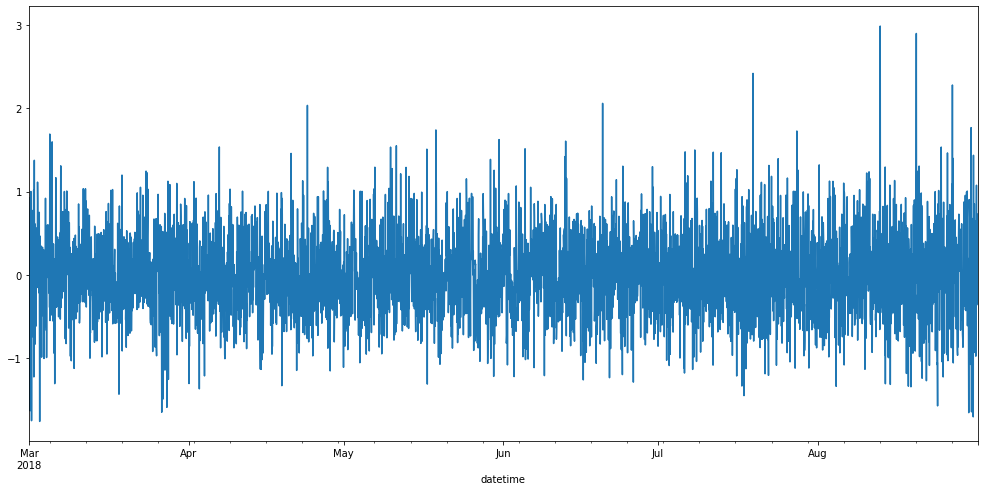

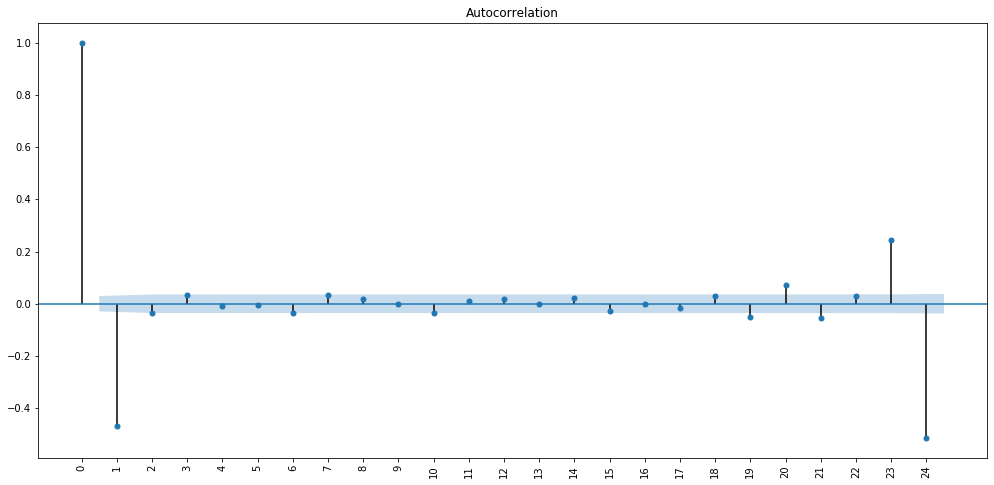

In [48]:
bm_resid = best_model.resid #остатки и автокореляция
plt.figure(figsize=figsize)
plt.xticks(list(range(0,lags,24)),rotation=90)
ax = plt.subplot(111)
bm_resid.plot(ax=ax)

lags = 24
plt.figure(figsize=figsize)
plt.xticks(list(range(0,lags+1)),rotation=90)
ax = plt.subplot(111)
acf = plot_acf(time_list, lags=lags, ax=ax)

p_value = adfuller(bm_resid)[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

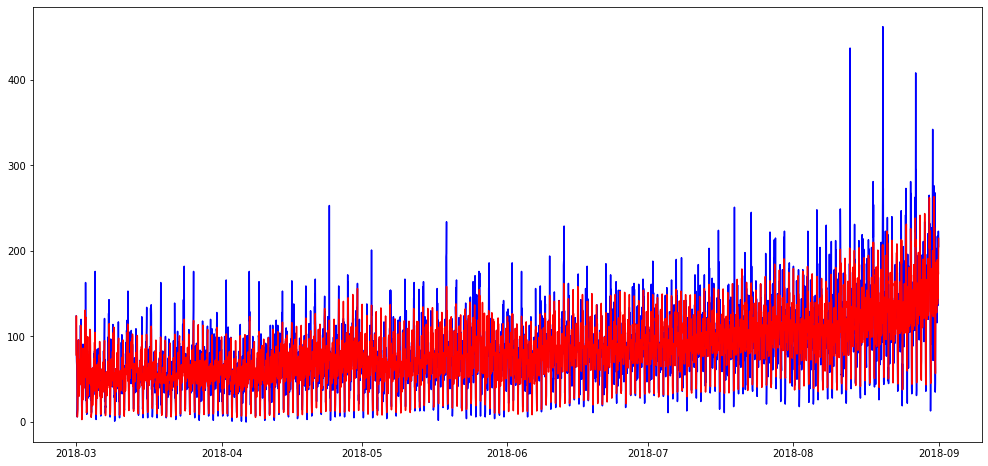

In [49]:
best_model_data = data_taxi_copy_BC.copy()
best_model_data['num_orders'] = best_model.fittedvalues

plt.figure(figsize=figsize)
plt.plot(data_taxi_copy.index, 
         data_taxi_copy['num_orders'], 
         'b-', 
         data_taxi_copy.index, 
         pt.inverse_transform(best_model_data),
         'r-')

Как видно модель SARIMA имеет напоминает оригинальные данные. Проведем кроссвалидацию данной модели.

In [50]:
def cv_time_series_rmse_SARIMA(data, target_column, n_splits, max_train_size):
    tscv = TimeSeriesSplit(n_splits = n_splits, max_train_size = max_train_size)
    RMSE = 0.0
    for train_index, test_index in tscv.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        train_BC = pt.fit_transform(train)
        SARIMA_model = sarimax.SARIMAX(train_BC, 
                       order=best_order, 
                       seasonal_order=best_seasonal_order).fit(disp=-1)
        predict_date_start = min(test_index)
        predict_date_end = max(test_index)
        predicted = test.copy()
        predicted[target_column] = SARIMA_model.predict(start=predict_date_start,
                                                        end=predict_date_end)
        predicted = pt.inverse_transform(predicted)
        RMSE += mean_squared_error(test[target_column], predicted) ** 0.5
    return RMSE / n_splits

cv_train_test_split = (train.shape[0] * 4 //5)

best_order=[2, 1, 1]
best_seasonal_order=[1, 1, 1, 24]
train_SARIMA, test_SARIMA = train_test_split(data_taxi_copy, shuffle=False, test_size=0.1, random_state=24072020)



Очищаем память для ускорения работы ядра.

In [51]:
del d
del D
del s
del best_model
del data_taxi_copy_BC
del data_taxi_copy_BC_D1
del data_taxi_copy_BC_D1_d1
del ax
del result
del best_aic
del best_param

In [52]:
%%time

cv_RMSE_SARIMA = cv_time_series_rmse_SARIMA(data=train_SARIMA, 
                                            target_column='num_orders', 
                                            n_splits=cv_splits, 
                                            max_train_size=cv_train_test_split)
print('Mean RMSE from CV of SARIMA =', cv_RMSE_SARIMA)

Mean RMSE from CV of SARIMA = 34.86598377023756
CPU times: user 2min 6s, sys: 53.2 s, total: 2min 59s
Wall time: 3min


# 4. Тестирование

Проведем обучение, предсказание и сравним предсказание с тестовыми данными.

### 4.1 Линейная регрессия

CPU times: user 102 ms, sys: 124 ms, total: 227 ms
Wall time: 186 ms


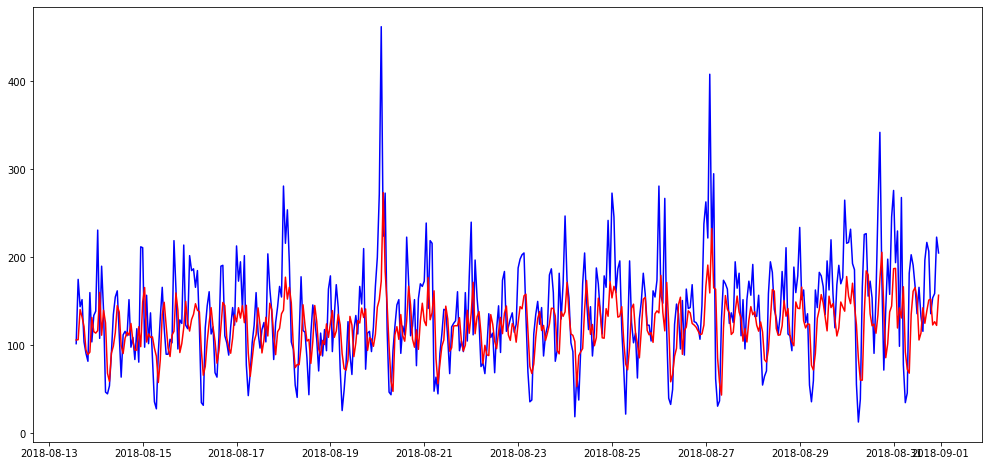

In [54]:
%%time

model = LinearRegression()
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.2 Регрессия Ridge

CPU times: user 75.1 ms, sys: 25.4 ms, total: 100 ms
Wall time: 55.4 ms


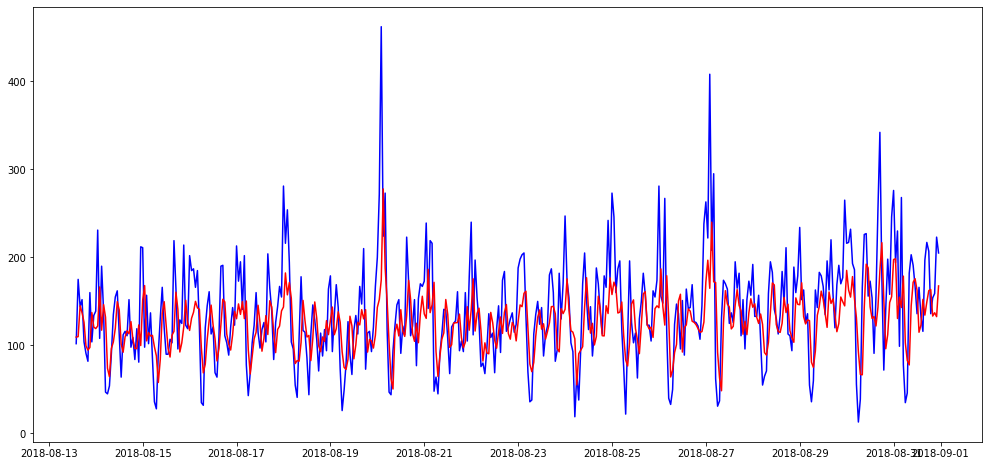

In [55]:
%%time

model = Ridge()
model.set_params(**best_params_R)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_R = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.3 Регрессия DecisionTreeRegressor

CPU times: user 42.1 ms, sys: 2.86 ms, total: 44.9 ms
Wall time: 42.8 ms


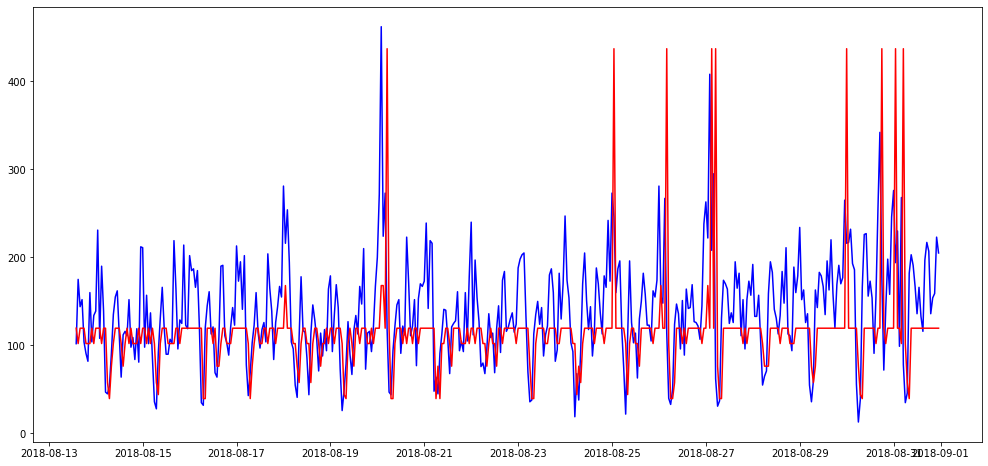

In [56]:
%%time

model = DecisionTreeRegressor()
model.set_params(**best_params_DTR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_DTR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.4 ExtraTreesRegressor

CPU times: user 4.16 s, sys: 0 ns, total: 4.16 s
Wall time: 4.16 s


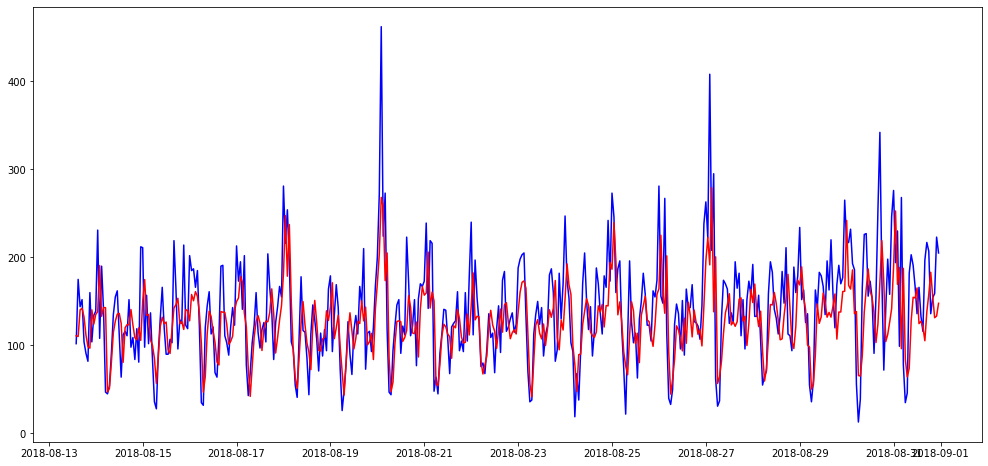

In [57]:
%%time

model = ExtraTreesRegressor()
model.set_params(**best_params_ETR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_ETR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.5 Регрессия CatBoostRegressor

CPU times: user 21.6 s, sys: 3.01 s, total: 24.6 s
Wall time: 26.8 s


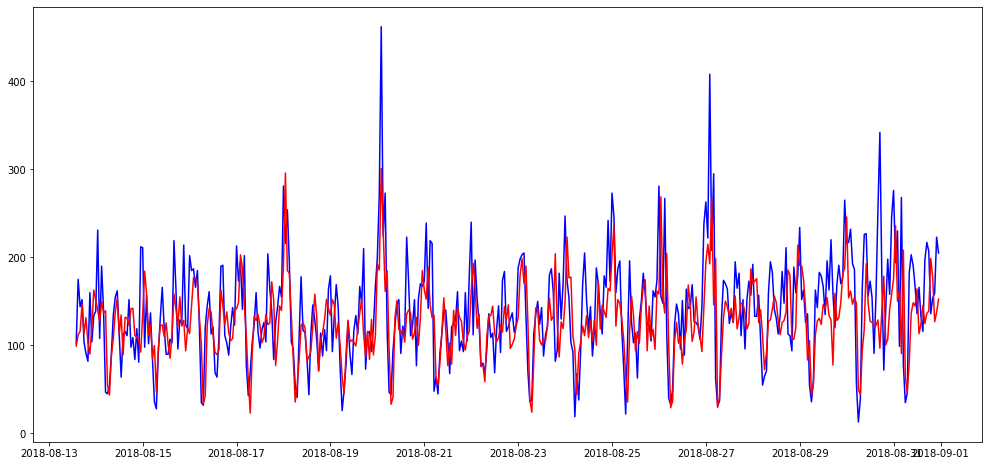

In [58]:
%%time

model = CatBoostRegressor()
model.set_params(**best_params_CBR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

CPU times: user 19.3 s, sys: 2.91 s, total: 22.3 s
Wall time: 23.5 s


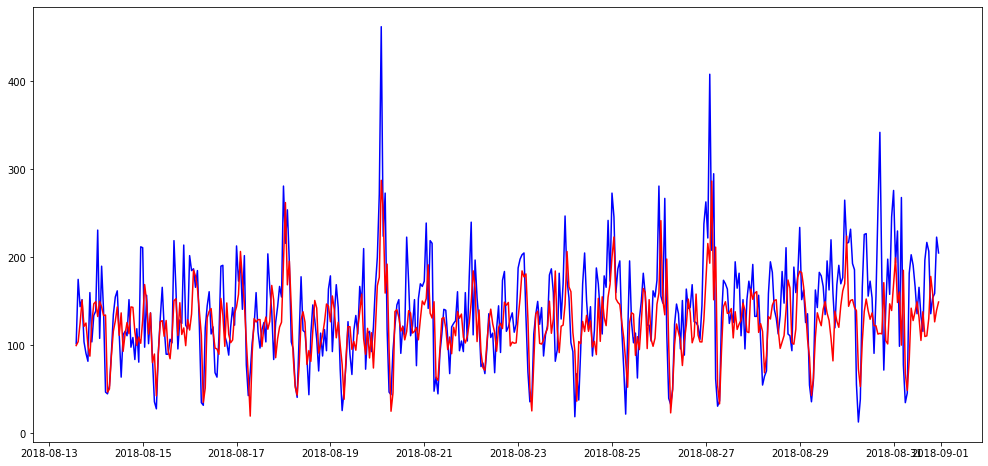

In [59]:
%%time

model = CatBoostRegressor(verbose=False)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_CBR_no_params = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.6 Регрессия LGBMRegressor

CPU times: user 1.61 s, sys: 6.21 ms, total: 1.62 s
Wall time: 1.6 s


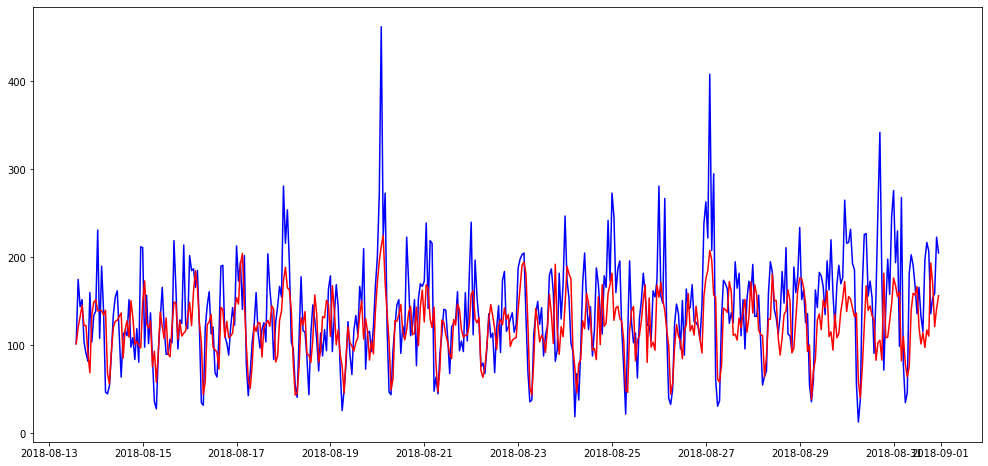

In [60]:
%%time

model = LGBMRegressor()
model.set_params(**best_params_LGBMR)
model.fit(train_features, train_target)
target_predict = model.predict(test_features)
final_RMSE_LGBMR = mean_squared_error(test_target, target_predict) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_target.index, 
         test_target, 
         'b-', 
         test_target.index, 
         target_predict,
         'r-')

### 4.7 Регрессия SARIMA

CPU times: user 57.7 s, sys: 18.9 s, total: 1min 16s
Wall time: 1min 16s


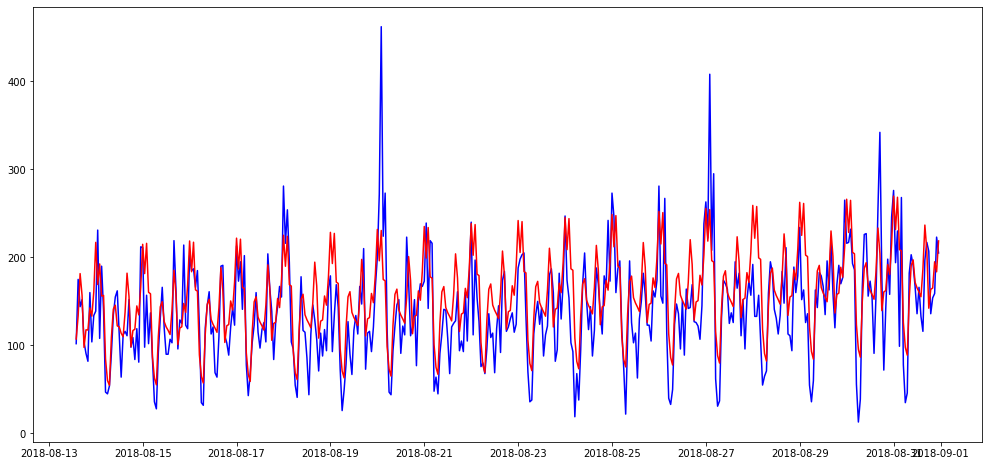

In [61]:
%%time

train_SARIMA_BC = pt.fit_transform(train_SARIMA)
SARIMA_model = sarimax.SARIMAX(train_SARIMA_BC, 
                               order=best_order, 
                               seasonal_order=best_seasonal_order).fit(disp=-1)
predict_date_start = train_SARIMA.shape[0]
predict_date_end = predict_date_start + test_SARIMA.shape[0] - 1
predicted = test_SARIMA.copy()
predicted['num_orders'] = SARIMA_model.predict(start=predict_date_start,
                                               end=predict_date_end)
predicted = pt.inverse_transform(predicted)
final_RMSE_SARIMA= mean_squared_error(test_SARIMA['num_orders'], predicted) ** 0.5

plt.figure(figsize=figsize)
plt.plot(test_SARIMA.index, 
         test_SARIMA['num_orders'], 
         'b-', 
         test_SARIMA.index, 
         predicted,
         'r-')

In [61]:
index = ['LinearRegression',
         'Ridge',
         'DecisionTreeRegressor',
         'ExtraTreeRegressor',
         'CatBoostRegressor',
         'CatBoostRegressor no userparameters',
         'LGBMRegressor',
         'SARIMA']
data = {'RMSE на CV':[cv_RMSE_LR,
                      cv_RMSE_R,
                      cv_RMSE_DTR,
                      cv_RMSE_ETR,
                      cv_RMSE_CBR,
                      cv_RMSE_CBR_no_params,
                      cv_RMSE_LGBMR,
                      cv_RMSE_SARIMA],
        'RMSE модели на тестовой выборке':[final_RMSE_LR,
                                           final_RMSE_R,
                                           final_RMSE_DTR,
                                           final_RMSE_ETR,
                                           final_RMSE_CBR,
                                           final_RMSE_CBR_no_params,
                                           final_RMSE_LGBMR,
                                           final_RMSE_SARIMA]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE на CV'] = (scores_data['RMSE на CV'].min() /
                              scores_data['RMSE на CV'])
scores_data['Выполнение задачи'] = scores_data['RMSE модели на тестовой выборке'] < 48.0
scores_data

RMSE на CV  \
LinearRegression                      32.410656   
Ridge                                 32.690895   
DecisionTreeRegressor                 34.855666   
ExtraTreeRegressor                    30.915426   
CatBoostRegressor                     31.869532   
CatBoostRegressor no userparameters   31.210212   
LGBMRegressor                         32.071584   
SARIMA                                34.865984   

                                     RMSE модели на тестовой выборке  \
LinearRegression                                           52.950578   
Ridge                                                      51.651011   
DecisionTreeRegressor                                      72.701123   
ExtraTreeRegressor                                         49.010429   
CatBoostRegressor                                          49.699185   
CatBoostRegressor no userparameters                        50.432440   
LGBMRegressor                                              51.103901   
SARIMA                                                     42.469761   

                                     Рейтинг RMSE на CV  Выполнение задачи  
LinearRegression                               0.953866              False  
Ridge                                          0.945689              False  
DecisionTreeRegressor                          0.886956              False  
ExtraTreeRegressor                             1.000000              False  
CatBoostRegressor                              0.970062              False  
CatBoostRegressor no userparameters            0.990555              False  
LGBMRegressor                                  0.963951              False  
SARIMA                                         0.886693               True

## Итоговый вывод

Во время проекта были изучены способы предсказания веременных рядов за счет регрессоров и аналитической модели SARIMA.

В таблицу внесен CatBoostRegressor без указания параметров. Регрессор самостоятельно ищет лучшие параметры для выполнения задачи. 

Исходя из финальной таблицы лучше всело предсказала ряд модель SARIMA. Это единственная модель, которая имеет достаточно низкое RMSE = 42,47. Это означает, что модель в среднем ошибаетс на 42-43 заказа такси в час. 

По рейтингу на кросс валидации лучше всего себя показал ExtraTreeRegressor. Только он не выполнил поставленную задачу на 1 пункт, значит требуется дальнейшая доработка.

В целом данные имеют очень много шумов, которые влияют на все стандартные регрессоры.